# 🤖 Classic ML Models with Benchmark Evaluation 📈

<a id="section-zero"></a>
# Introduction
Banks are often exposed to fraudulent transactions and they're constantly improving systems to track them. My goal is to train eight (8) machine learning models that will detect those fraudulent transactions.

The models will be trained using a bank dataset that contains 20k+ transactions with 112 anonymized numerical features.

In [2]:
import os
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

Read and display data.

In [4]:
# Set working directory and read data
data = pd.read_csv('dataset/fraud_detection_bank_dataset.csv') 
data

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,0,9,1354,0,18,0,1,7,9,0,...,0,0,0,1,1,0,0,0,49,1
1,1,0,239,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,2,0,260,0,4,0,3,6,0,0,...,0,0,0,1,1,0,0,0,56,1
3,3,17,682,0,1,0,0,8,17,0,...,0,1,0,1,1,0,0,0,65,1
4,4,1,540,0,2,0,1,7,1,0,...,0,0,0,1,1,0,0,0,175,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20463,20463,0,88,0,0,0,2,-1,0,0,...,0,1,0,0,0,0,1,0,85,0
20464,20464,0,134,0,2,0,0,6,0,0,...,0,0,0,0,0,0,0,0,7,0
20465,20465,4,393,1,1,0,0,-1,4,0,...,0,1,0,0,0,0,0,0,45,0
20466,20466,0,10,0,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,5,0


Drop the first column and rename the last column. Check for any null values.

In [6]:
# Remove the 1st column (Unnamed).
data = data.iloc[:,1:]

# Rename "targets" column to "is_fraud".
data.rename(columns={'targets': 'is_fraud'}, inplace=True) 

# Check for any null values in each column
print(f'Null Values: {sum(data.isnull().sum())}')

Null Values: 0


Determine the class balance between non-fraudulent and fraudulent objects.

In [8]:
# Obtain the number of fraud & non-fraud objects.
class_balance = data.is_fraud.value_counts()
fraud_percentage = ((class_balance[1]/len(data))*100)

print(f'Non-Fraud: {class_balance[0]} '
      f'({(100-fraud_percentage).__round__(4)}%)')
print(f'Fraud: {class_balance[1]} '
      f'({fraud_percentage.__round__(4)}%)')

Non-Fraud: 15030 (73.4317%)
Fraud: 5438 (26.5683%)


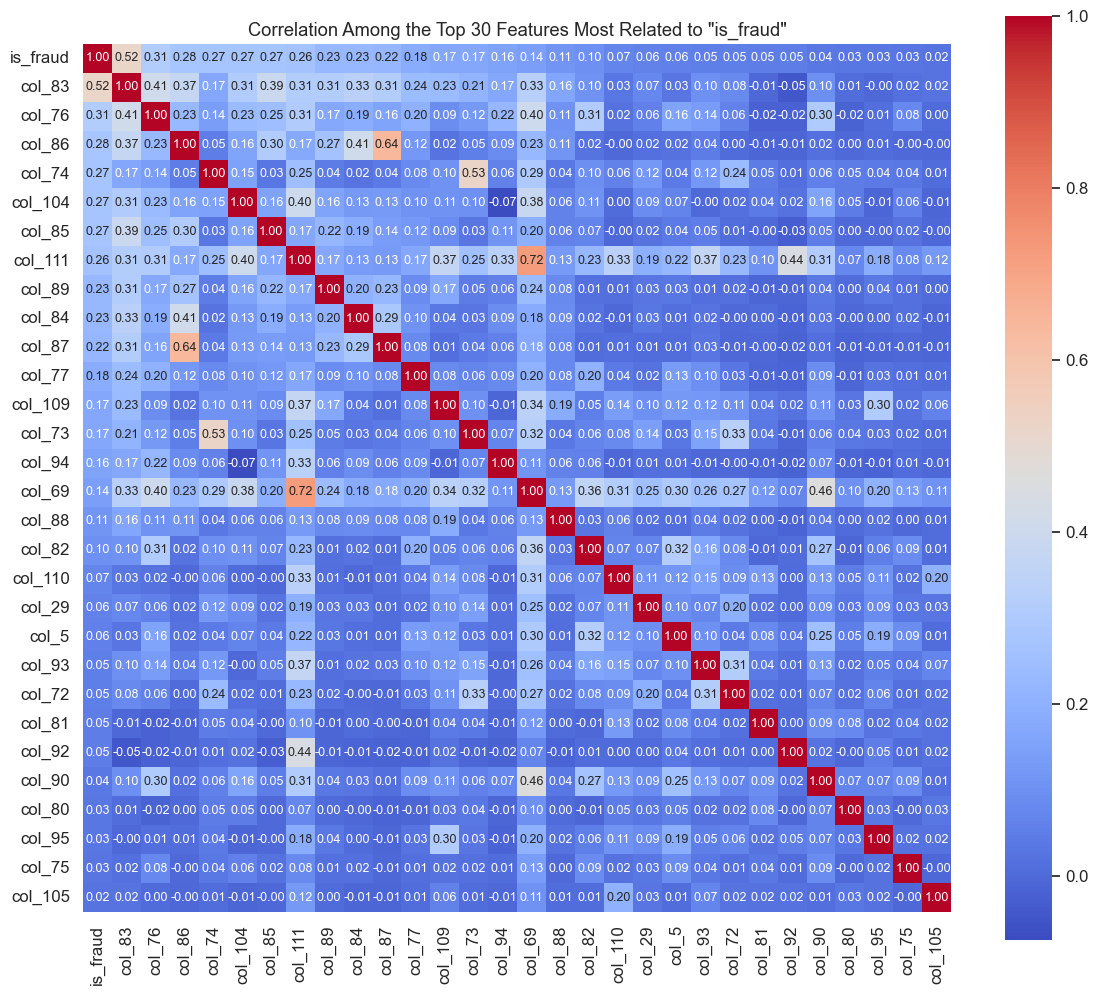

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corrmat = data.corr()

# Select the top 30 features most correlated with 'is_fraud'
k = 30
cols = corrmat.nlargest(k, 'is_fraud')['is_fraud'].index

# Compute the correlation matrix for these selected features
cm = np.corrcoef(data[cols].values.T)

# Set the style and generate the heatmap
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.1)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values,
            cmap='coolwarm')

plt.title('Correlation Among the Top 30 Features Most Related to "is_fraud"')
plt.savefig('img/correlation_heatmap_top_30_features.png', bbox_inches='tight')
plt.show()


Separate dataset into features (inputs) and targets (outputs). Verify all features are numerical and split dataset into training (80%) and testing (20%).

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
test_data_fraction = 0.2 # Allocate 20% of the data for testing.
random_seed = 25

X = data.iloc[:,0:-1] # Features (inputs).
y = data.is_fraud # Target (output).

# Verify all features are numerical
print(f'Feature Datatypes\n-----------------\n'
      f'{X.dtypes.value_counts()}\n')

# Split data into training (80%) and testing (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_data_fraction, 
                                                    random_state=random_seed)
# Obtain shape of training and testing data.
print('Training Shape\n--------------')
print(f'Input: {X_train.shape}')
print(f'Output: {y_train.shape}')

print('\nTesting Shape\n--------------')
print(f'Input: {X_test.shape}')
print(f'Output: {y_test.shape}')

Feature Datatypes
-----------------
int64      111
float64      1
dtype: int64

Training Shape
--------------
Input: (16374, 112)
Output: (16374,)

Testing Shape
--------------
Input: (4094, 112)
Output: (4094,)


Initialize functions that later will be used to analyze data.

In [14]:
def get_indices(lst, val):
    '''
    Input: 
        lst: a list of elements (string, integer, float, etc).
        val: the value being searched for in the list.
        
    Output: 
        indices: list of all indices that are equal to val.
    '''
    # Gets all the indices of a element in a list.
    indices = []
    
    for i in range(len(lst)):
        if lst[i] == val:
            indices.append(i)
            
    return indices

In [15]:
def get_bestParam(param_values, train_acc, test_acc):
    '''
    Input: 
        param_values: a list containing all of the parameter values tried
        train_acc: a list containing the training accuracy for a model trained 
                   with each parameter in param_values.
        test_acc: a list containing testing accuracy for a model trained with 
                  each parameter in param_values.
        
    Output: 
        best_param: the alpha value that produces the highest test_acc with 
                    the minimum difference (train_acc - test_acc).
        best_train_acc: the training value that is the closest to the best_test_acc.
        best_test_acc: the highest testing accuracy.
    '''
    # Gets all the indices of the maximum test accuracy value.
    indices = get_indices(test_acc, max(test_acc))

    diff = []
    params = []
    train_accuracy = []
    test_accuracy = []
    
    for i in indices:
        # Calculate the difference between the training and testing 
        # accuracy based on the indices.
        diff.append(abs(train_acc[i] - test_acc[i]))
        params.append(param_values[i])
        train_accuracy.append(train_acc[i])
        test_accuracy.append(test_acc[i])
        
    # Get the index of the minimum difference in the list.
    min_diff_idx = diff.index(min(diff))
    # Get the best param using the minimum difference index.
    best_param = params[min_diff_idx]
    # Get the best training accuracy using the minimum difference index.
    best_train_acc = train_accuracy[min_diff_idx] 
    # Get the best testing accuracy using the minimum difference index.
    best_test_acc = test_accuracy[min_diff_idx] 
    
    return best_param, best_train_acc, best_test_acc

In [16]:
def disp_confMatrix():
    cm = confusion_matrix(y_test, y_test_predicted)
    cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(7,7))
    cmp.plot(ax=ax)
    plt.show()
    
    return None

In [17]:
def save_metrics():
    # Calculate accuracy for training and testing data.
    train_accs.append(accuracy_score(y_train, y_train_predicted).__round__(4))
    test_accs.append(accuracy_score(y_test, y_test_predicted).__round__(4))

    # Calculate F1 score for training and testing data.
    train_f1_scores.append(f1_score(y_train, y_train_predicted).__round__(4))
    test_f1_scores.append(f1_score(y_test, y_test_predicted).__round__(4))

    # Obtain the false-positives and false-negatives from the testing data.
    false_pos.append(confusion_matrix(y_test, y_test_predicted)[0,1]) 
    false_neg.append(confusion_matrix(y_test, y_test_predicted)[1,0]) 
    
    return None

Initialize lists for storing metrics.

In [19]:
target_names = ['non-fraud (0)', 'fraud (1)'] # Used for classification report.
false_pos = [] # Create list for false-positives.
false_neg = [] # Create list for false-negatives.
train_f1_scores = [] # Create list for training data F1 scores.
test_f1_scores = []  # Create list for testing data F1 scores.
train_accs = [] # Create list for training data accuracies.
test_accs = []  # Create list for testing data accuracies.
clf_names = ['Dummy', 'Decision Tree', 'AdaBoost', 'KNN', 'MLP', 
             'Logistic\nRegression', 'Random\nForest', 'SVM']

<a id="section-one"></a>
# Training & Testing ML Models

I will be training and testing eight (8) different ML models using *k*-fold cross-validation (CV) with hyper-parameter tuning to reduce the chances of overfitting.

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import validation_curve

# Cross-validation value.
cv = 3 

<a id="section-two"></a>
## Dummy Classifier
This model was configured to always pick the majority class. I used this as a baseline to determine if the other models were doing better than a naive approach that wouldn't require any real training. 

In [23]:
from sklearn.dummy import DummyClassifier

Train and fit data to the model. Predict training and testing class. Display the classification report.

In [25]:
# Create model and fit model to the training data.
dum = DummyClassifier(strategy='most_frequent', random_state=random_seed)
dum.fit(X_train, y_train)

# Predict training & testing class.
y_train_predicted = dum.predict(X_train)
y_test_predicted = dum.predict(X_test)

# Display classification report for training & testing data.
print(f"Classification Report with strategy = 'most_frequent'\n")
print(f'\t\t    Dummy Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print(f'\t\t    Dummy Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4))

Classification Report with strategy = 'most_frequent'

		    Dummy Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.7340    1.0000    0.8466     12019
    fraud (1)     0.0000    0.0000    0.0000      4355

     accuracy                         0.7340     16374
    macro avg     0.3670    0.5000    0.4233     16374
 weighted avg     0.5388    0.7340    0.6214     16374
 

		    Dummy Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.7355    1.0000    0.8476      3011
    fraud (1)     0.0000    0.0000    0.0000      1083

     accuracy                         0.7355      4094
    macro avg     0.3677    0.5000    0.4238      4094
 weighted avg     0.5409    0.7355    0.6234      4094



Calculate probability score, precision and recall. Then, plot the AUC-PR.

*Note: AUC-PR stands for area under the (precision-recall) curve. Generally, the higher the AUC-PR score, the better a classifier performs for the given task.*

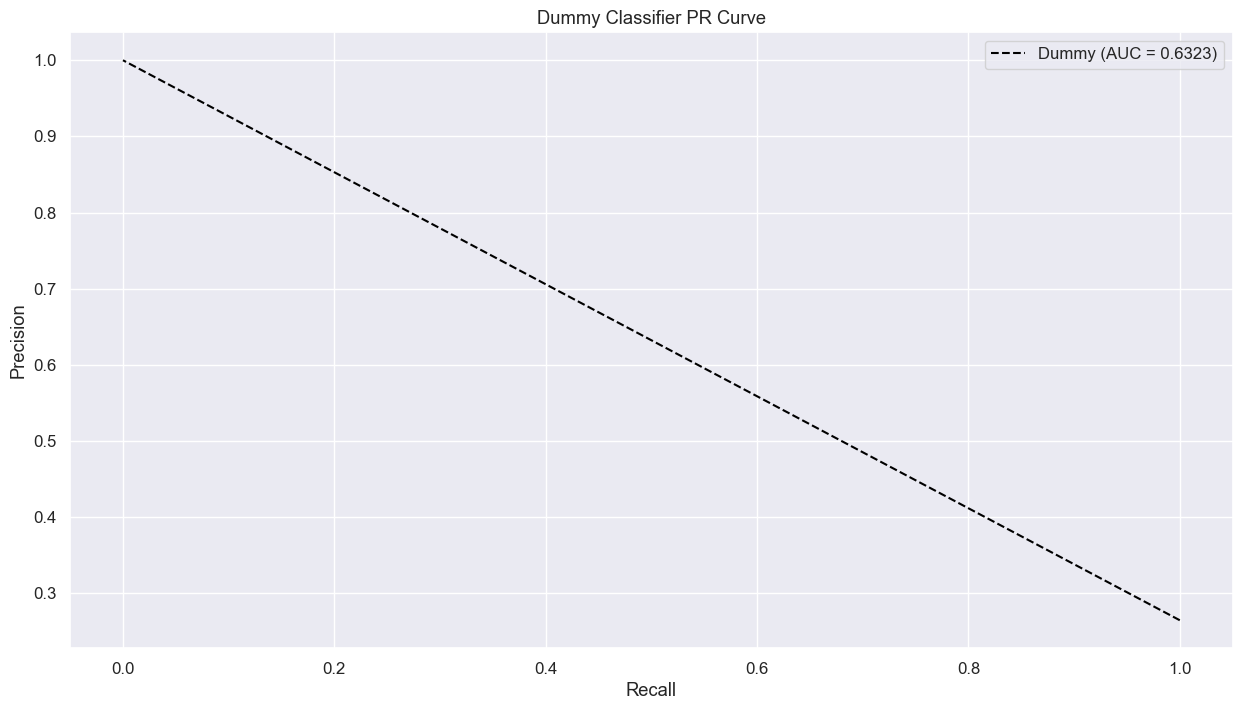

In [29]:
# Predict class probabilities for testing data.
y_score = dum.predict_proba(X_test)[:, 1] 

# Compute precision-recall pairs for different probability thresholds.
dum_precision, dum_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
dum_auc = auc(dum_recall, dum_precision).__round__(4)
              
plt.figure(figsize=(15,8))            
plt.plot(dum_recall, dum_precision, color='black', linestyle='--')
plt.legend([f'Dummy (AUC = {dum_auc})'])
plt.title(f'Dummy Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Store metrics to the list.

In [31]:
save_metrics()

<a id="section-three"></a>
## Decision Tree Classifier
### Choosing a `ccp_alpha` value that would produce the highest validation accuracy score.

In [33]:
from sklearn.tree import DecisionTreeClassifier

Best Alpha: 0.00027
Training Accuracy: 0.9478136069378283
Validation Accuracy: 0.915720043972151


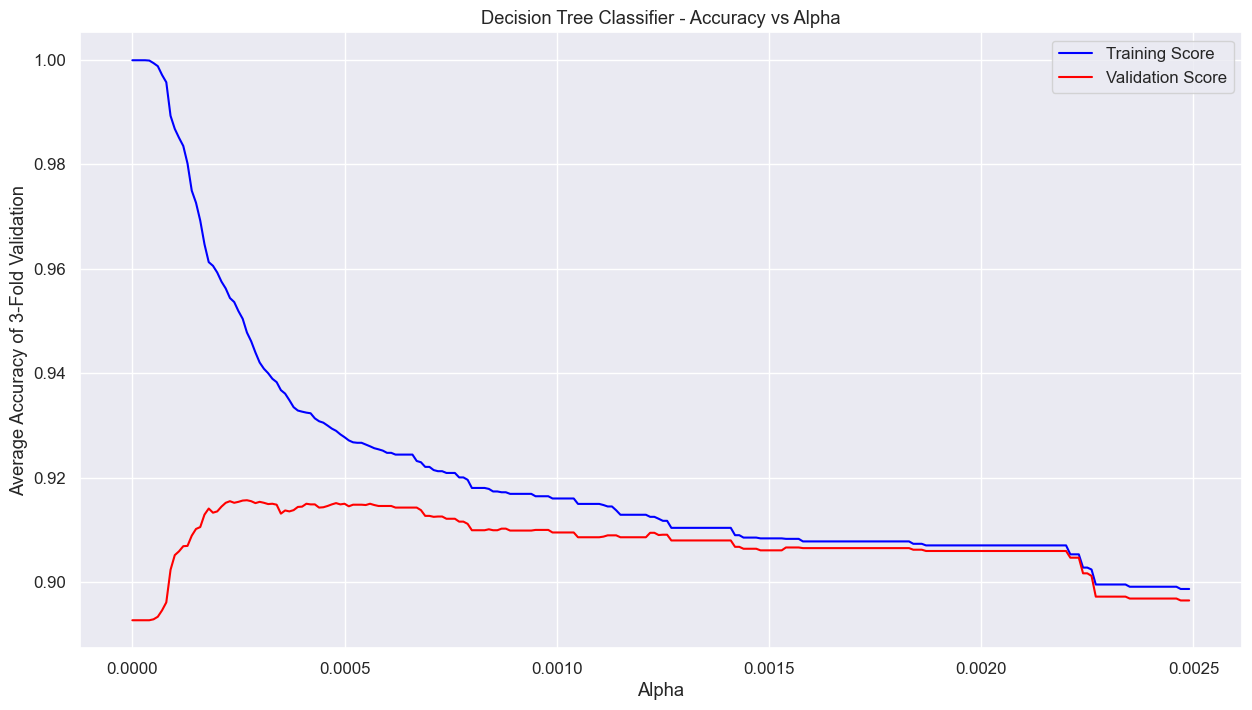

In [34]:
# Create model.
dtc = DecisionTreeClassifier(criterion="gini", random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
alpha_values = np.arange(0, 0.0025, 0.00001)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(dtc, X_train, y_train, 
                                              param_name='ccp_alpha', 
                                              param_range=alpha_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_alpha, best_train, best_valid = get_bestParam(alpha_values, train_scores, 
                                                   valid_scores)

# Display best parameter values.
print(f'Best Alpha: {best_alpha}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Alpha for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(alpha_values, train_scores, color='blue')
plt.plot(alpha_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title(f'Decision Tree Classifier - Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [35]:
# Create model and fit model to the training data.
dtc = DecisionTreeClassifier(criterion='gini', random_state=random_seed, 
                             ccp_alpha=best_alpha)
dtc.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = dtc.predict(X_train)
y_test_predicted = dtc.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with ccp_alpha = {best_alpha}\n')
print('\t\tDecision Tree Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\tDecision Tree Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4))

Classification Report with ccp_alpha = 0.00027

		Decision Tree Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9509    0.9613    0.9561     12019
    fraud (1)     0.8899    0.8629    0.8762      4355

     accuracy                         0.9351     16374
    macro avg     0.9204    0.9121    0.9161     16374
 weighted avg     0.9346    0.9351    0.9348     16374
 

		Decision Tree Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9355    0.9482    0.9418      3011
    fraud (1)     0.8503    0.8181    0.8339      1083

     accuracy                         0.9138      4094
    macro avg     0.8929    0.8831    0.8878      4094
 weighted avg     0.9129    0.9138    0.9132      4094



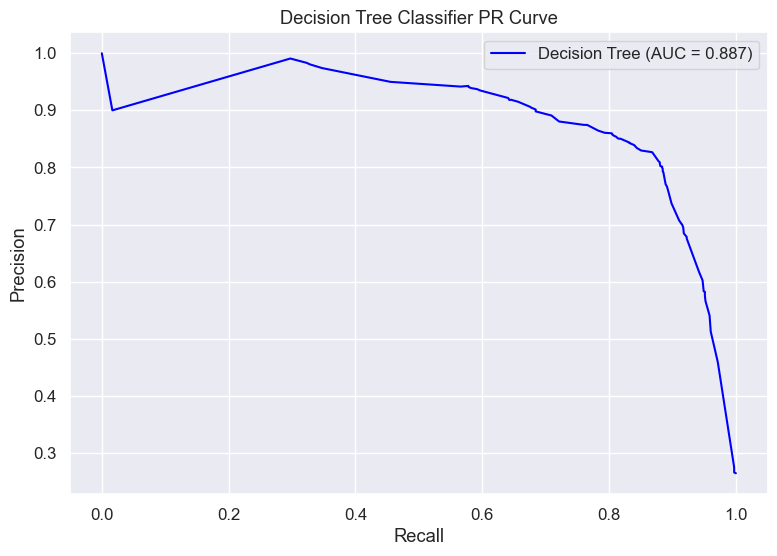

In [37]:
# Predict class probabilities for testing data.
y_score = dtc.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
dtc_precision, dtc_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
dtc_auc = auc(dtc_recall, dtc_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(dtc_recall, dtc_precision, color='blue')
plt.legend([f'Decision Tree (AUC = {dtc_auc})'])
plt.title(f'Decision Tree Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `ccp_alpha` value that would produce the highest testing F1 score.

The F1 score (also known as balanced F-score or F-measure) can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The F1 score is dependent upon recall and precision. The higher the recall and precision, the higher the F1 score. To increase recall and precision, I must reduce false-negatives and false-positives.

Recall = TP/(TP + FN)<br> 
Precision = TP/(TP + FP)<br> 

F1 Score = 2 x (Recall x Precision)/(Recall + Precision)

In [39]:
fraud_train_f1_score = [] 
fraud_test_f1_score = []

for alpha in alpha_values:
    # Create model and fit model to the training data.
    dtc = DecisionTreeClassifier(criterion='gini', random_state=random_seed, 
                                 ccp_alpha=alpha)
    dtc.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = dtc.predict(X_train)
    y_test_predicted = dtc.predict(X_test)
    
    # Calculate F1 score for training and testing data.
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Alpha: 0.00023
Training F1 Score: 0.8838
Testing F1 Score: 0.8457


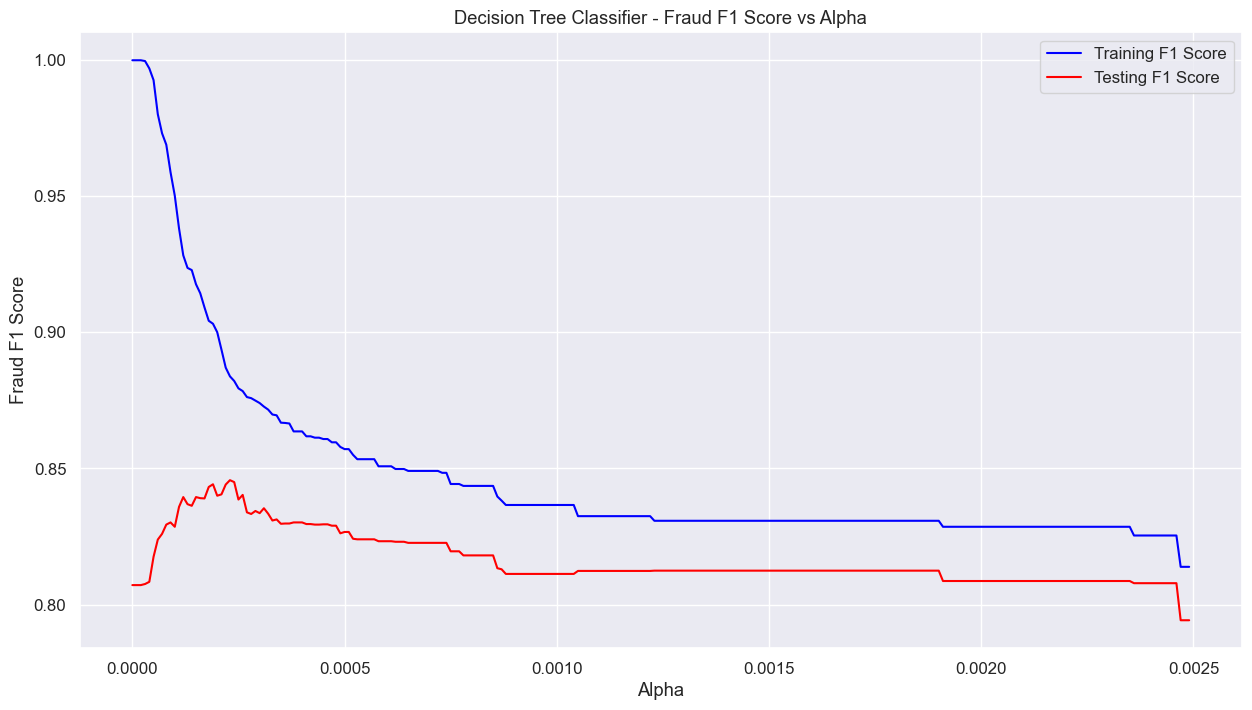

In [40]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_alpha, best_train, best_test = get_bestParam(alpha_values, fraud_train_f1_score, 
                                                  fraud_test_f1_score)

# Display best parameter values.
print(f'Best Alpha: {best_alpha}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Alpha for testing and training data.
plt.figure(figsize=(15,8))
plt.plot(alpha_values, fraud_train_f1_score, color='blue')
plt.plot(alpha_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title(f'Decision Tree Classifier - Fraud F1 Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel(f'Fraud F1 Score')
plt.show()

In [41]:
# Create model and fit model to the training data.
dtc = DecisionTreeClassifier(criterion='gini', random_state=random_seed, 
                             ccp_alpha=best_alpha)
dtc.fit(X_train, y_train)

# Predict training & testing class.
y_train_predicted = dtc.predict(X_train)
y_test_predicted = dtc.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with ccp_alpha = {best_alpha}\n')
print('\t\tDecision Tree Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\tDecision Tree Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4))

Classification Report with ccp_alpha = 0.00023

		Decision Tree Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9541    0.9632    0.9586     12019
    fraud (1)     0.8958    0.8721    0.8838      4355

     accuracy                         0.9390     16374
    macro avg     0.9249    0.9177    0.9212     16374
 weighted avg     0.9386    0.9390    0.9387     16374
 

		Decision Tree Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9411    0.9499    0.9455      3011
    fraud (1)     0.8569    0.8347    0.8457      1083

     accuracy                         0.9194      4094
    macro avg     0.8990    0.8923    0.8956      4094
 weighted avg     0.9188    0.9194    0.9191      4094



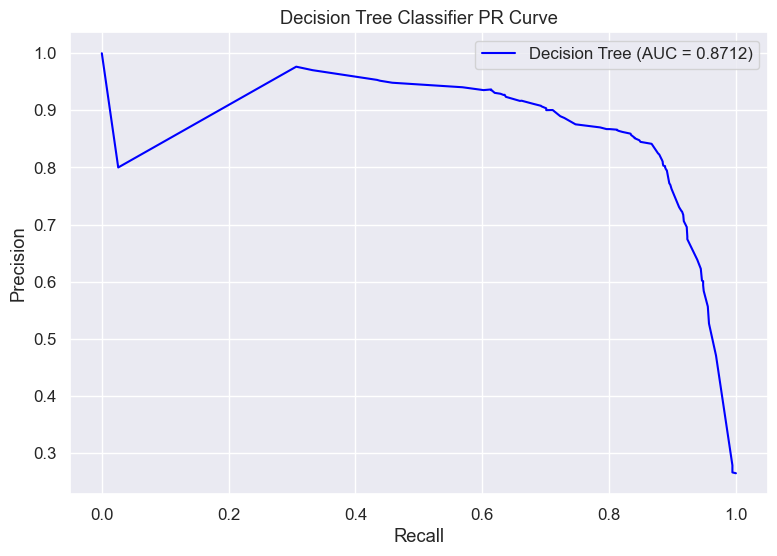

In [43]:
# Predict class probabilities for testing data.
y_score = dtc.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
dtc_precision, dtc_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
dtc_auc = auc(dtc_recall, dtc_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(dtc_recall, dtc_precision, color='blue')
plt.legend([f'Decision Tree (AUC = {dtc_auc})'])
plt.title(f'Decision Tree Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [44]:
save_metrics()

As result of choosing an alpha that would produce the highest testing F1 score, I was able to reduce FP and FN while increasing TP & TN. 

- FP decreased by **3.21%**
- FN decreased by **9.14%**
- TP increased by **2.03%**
- TN increased by **0.18%** 

#### Training Metrics
- Precision increased by **0.66%**<br>
- Recall increased by **1.07%**<br>
- F1 score increased by **0.87%**<br>

#### Testing Metrics
- Precision increased by **0.78%**<br>
- Recall increased by **2.03**%<br>
- F1 score increased by **1.42%**<br>

I initially chose `ccp_alpha` based on the accuracy of the training and validation data. However, when choosing `ccp_alpha`  based on the F1 score, it not only improved recall and precision but it also improved the accuracy by **0.61%**. Moving forward, I will compare these two (2) methods and choose the model that performs best.

<a id="section-four"></a>
## AdaBoost Classifier
### Choosing a `n_estimators` value that would produce the highest validation accuracy score.

In [47]:
from sklearn.ensemble import AdaBoostClassifier

Best Estimator: 338
Training Accuracy: 0.9336753389519972
Validation Accuracy: 0.924697691462074


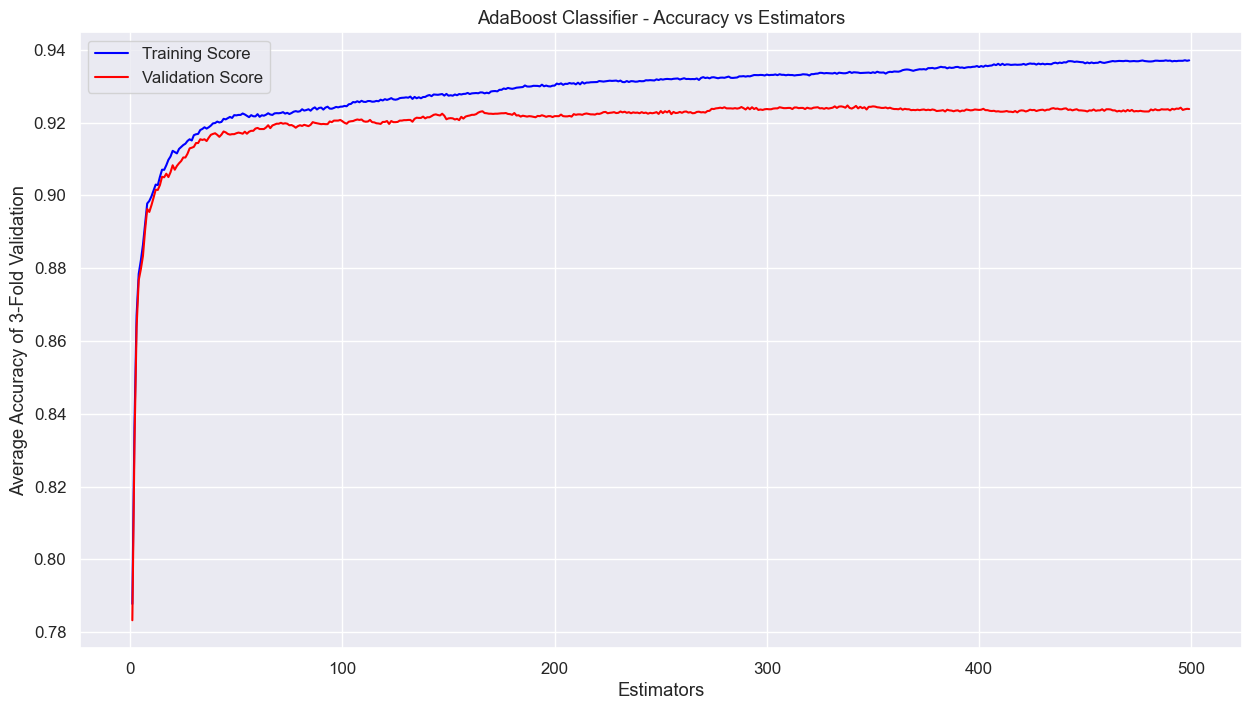

In [48]:
# Create model
ada = AdaBoostClassifier(random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
estimator_values = np.arange(1, 500, 1)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(ada, X_train, y_train, 
                                              param_name='n_estimators', 
                                              param_range=estimator_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_estimator, best_train, best_valid = get_bestParam(estimator_values, train_scores, 
                                                       valid_scores)

# Display best parameter values.
print(f'Best Estimator: {best_estimator}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Estimators for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(estimator_values, train_scores, color='blue')
plt.plot(estimator_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title('AdaBoost Classifier - Accuracy vs Estimators')
plt.xlabel('Estimators')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [49]:
# Create model and fit model to the training data.
ada = AdaBoostClassifier(n_estimators=best_estimator, random_state=random_seed)
ada.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = ada.predict(X_train)
y_test_predicted = ada.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with n_estimators = {best_estimator}\n')
print('\t\t  AdaBoost Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  AdaBoost Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_estimators = 338

		  AdaBoost Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9459    0.9631    0.9544     12019
    fraud (1)     0.8929    0.8480    0.8699      4355

     accuracy                         0.9325     16374
    macro avg     0.9194    0.9056    0.9122     16374
 weighted avg     0.9318    0.9325    0.9319     16374
 

		  AdaBoost Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9398    0.9548    0.9473      3011
    fraud (1)     0.8686    0.8301    0.8489      1083

     accuracy                         0.9218      4094
    macro avg     0.9042    0.8925    0.8981      4094
 weighted avg     0.9210    0.9218    0.9213      4094
 



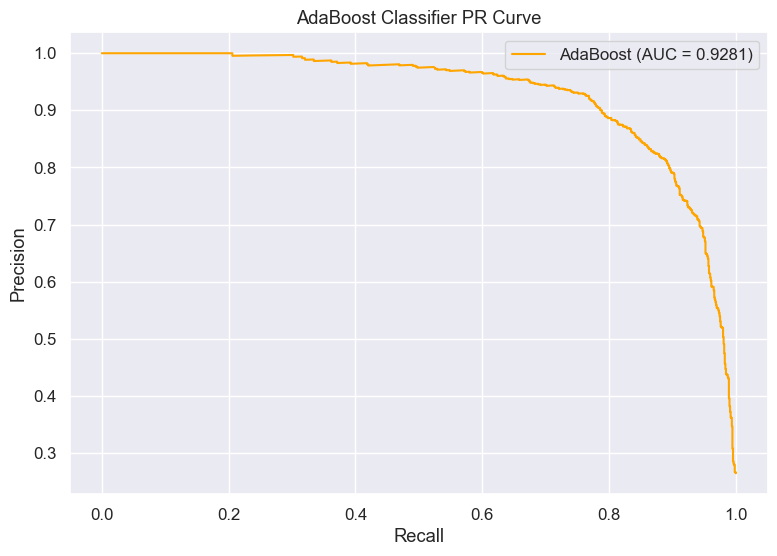

In [51]:
# Predict class probabilities for testing data.
y_score = ada.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
ada_precision, ada_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
ada_auc = auc(ada_recall, ada_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(ada_recall, ada_precision, color='orange')
plt.legend([f'AdaBoost (AUC = {ada_auc})'])
plt.title('AdaBoost Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `n_estimators` value that would produce the highest testing F1 score.

In [53]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for estimators in estimator_values:
    # Create model and fit model to the training data.
    ada = AdaBoostClassifier(n_estimators=estimators, random_state=random_seed)
    ada.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = ada.predict(X_train)
    y_test_predicted = ada.predict(X_test)
    
    # Calculate F1 score for training and testing data.    
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Estimator: 84
Training F1 Score: 0.8525
Testing F1 Score: 0.8538


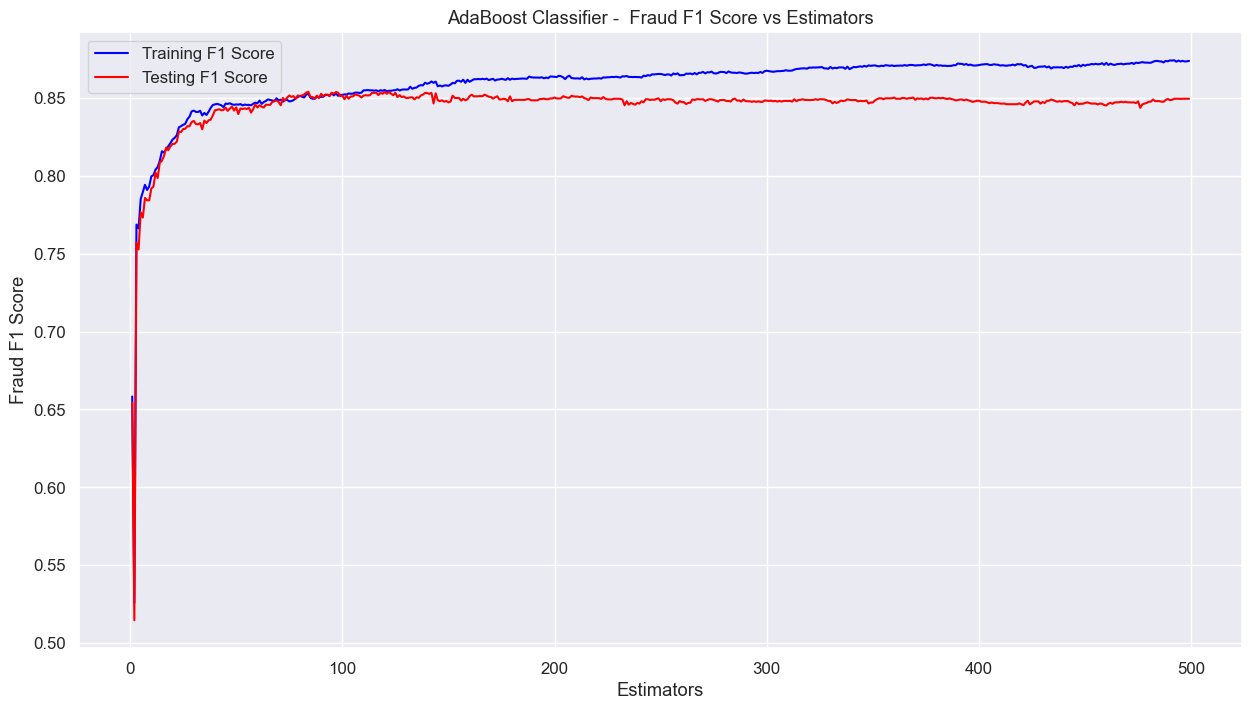

In [54]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_estimator, best_train, best_test = get_bestParam(
    estimator_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Estimator: {best_estimator}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Estimators for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(estimator_values, fraud_train_f1_score, color='blue')
plt.plot(estimator_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('AdaBoost Classifier -  Fraud F1 Score vs Estimators')
plt.xlabel('Estimators')
plt.ylabel(f'Fraud F1 Score')
plt.show()

In [55]:
# Create model and fit model to the training data.
ada = AdaBoostClassifier(n_estimators=best_estimator, random_state=random_seed)
ada.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = ada.predict(X_train)
y_test_predicted = ada.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with n_estimators = {best_estimator}\n')
print('\t\t  AdaBoost Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  AdaBoost Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_estimators = 84

		  AdaBoost Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9401    0.9567    0.9483     12019
    fraud (1)     0.8745    0.8317    0.8525      4355

     accuracy                         0.9235     16374
    macro avg     0.9073    0.8942    0.9004     16374
 weighted avg     0.9226    0.9235    0.9229     16374
 

		  AdaBoost Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9418    0.9562    0.9489      3011
    fraud (1)     0.8727    0.8356    0.8538      1083

     accuracy                         0.9243      4094
    macro avg     0.9072    0.8959    0.9013      4094
 weighted avg     0.9235    0.9243    0.9237      4094
 



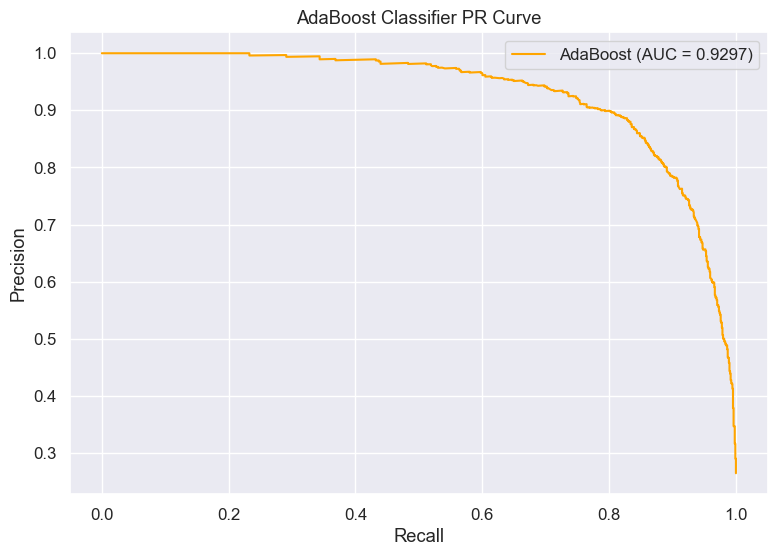

In [57]:
# Predict class probabilities for testing data.
y_score = ada.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
ada_precision, ada_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
ada_auc = auc(ada_recall, ada_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(ada_recall, ada_precision, color='orange')
plt.legend([f'AdaBoost (AUC = {ada_auc})'])
plt.title('AdaBoost Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [58]:
save_metrics()

<a id="section-five"></a>
## K Nearest Neighbors (KNN) Classifier
### Choosing a `n_neighbors` value that would produce the highest validation accuracy score.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

Best Neighbor: 12
Training Accuracy: 0.8622205936240381
Validation Accuracy: 0.8488457310370099


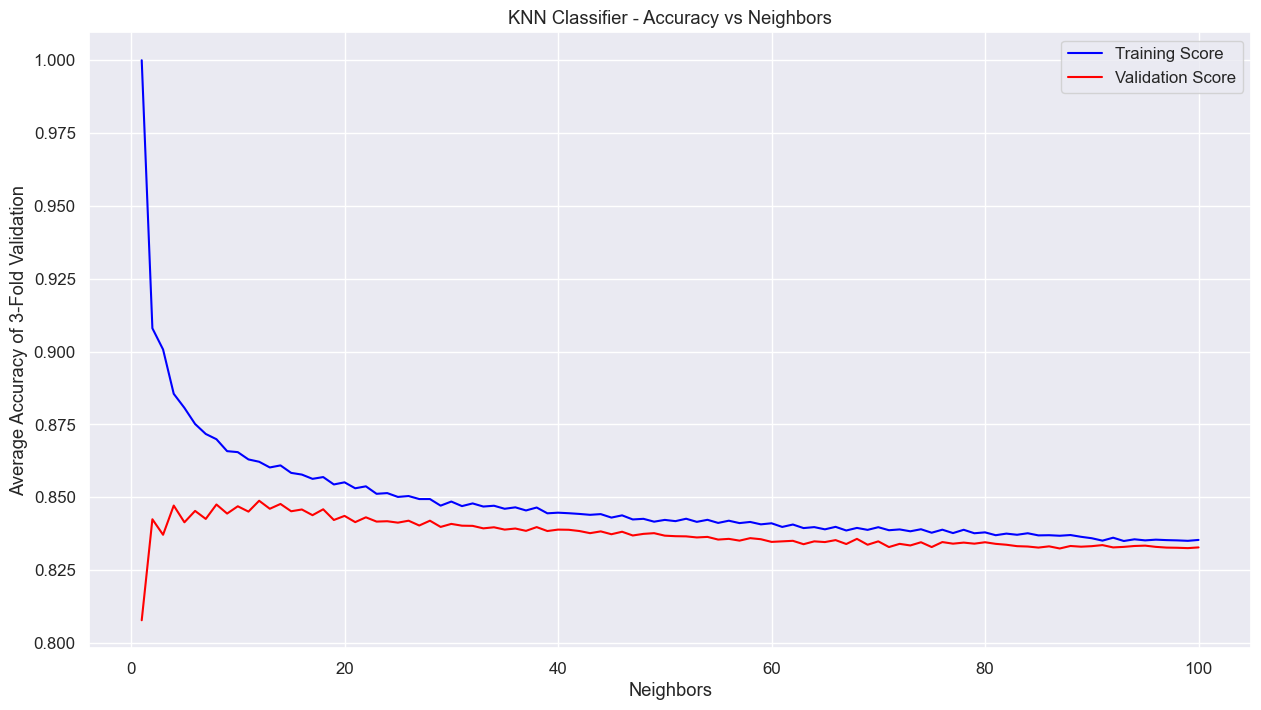

In [61]:
# Create model
knn = KNeighborsClassifier()

# Generates a list that starts at minimum, ends at maximum, and increments by step.
neighbor_values = np.arange(1, 101, 1)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(knn, X_train, y_train, 
                                              param_name='n_neighbors', 
                                              param_range=neighbor_values, cv=cv)
# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_neighbor, best_train, best_valid = get_bestParam(neighbor_values, train_scores, 
                                                      valid_scores)

# Display best parameter values.
print(f'Best Neighbor: {best_neighbor}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Neighbors for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(neighbor_values, train_scores, color='blue')
plt.plot(neighbor_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title('KNN Classifier - Accuracy vs Neighbors')
plt.xlabel('Neighbors')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [62]:
# Create model and fit model to the training data.
knn = KNeighborsClassifier(n_neighbors=best_neighbor)
knn.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = knn.predict(X_train)
y_test_predicted = knn.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with n_neighbors = {best_neighbor}\n')
print('\t\t     KNN Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t     KNN Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_neighbors = 12

		     KNN Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8776    0.9484    0.9116     12019
    fraud (1)     0.8168    0.6349    0.7145      4355

     accuracy                         0.8650     16374
    macro avg     0.8472    0.7917    0.8130     16374
 weighted avg     0.8614    0.8650    0.8592     16374
 

		     KNN Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8735    0.9332    0.9024      3011
    fraud (1)     0.7708    0.6242    0.6898      1083

     accuracy                         0.8515      4094
    macro avg     0.8221    0.7787    0.7961      4094
 weighted avg     0.8463    0.8515    0.8461      4094
 



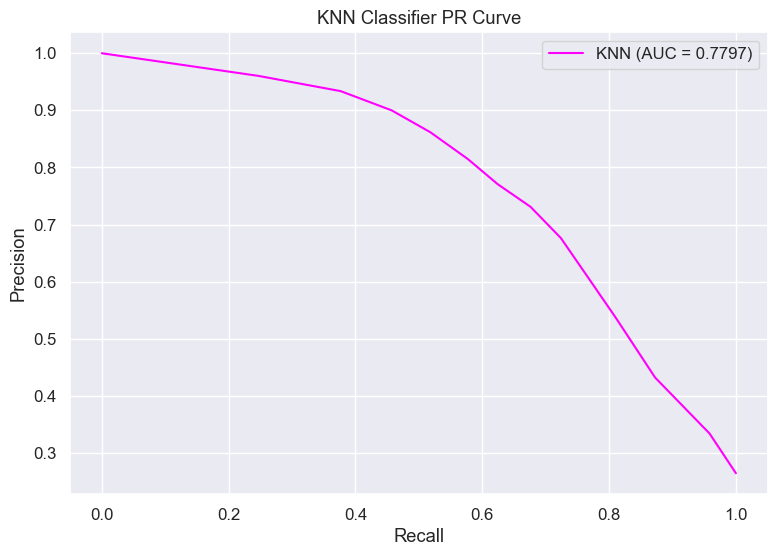

In [64]:
# Predict class probabilities for testing data.
y_score = knn.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
knn_auc = auc(knn_recall, knn_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(knn_recall, knn_precision, color='magenta')
plt.legend([f'KNN (AUC = {knn_auc})'])
plt.title('KNN Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `n_neighbors` value that would produce the highest testing F1 score.

In [66]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for neighbors in neighbor_values:
    # Create model and fit model to the training data.
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = knn.predict(X_train)
    y_test_predicted = knn.predict(X_test)
    
    # Calculate F1 score for training and testing data.    
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Neighbors: 5
Training F1 Score: 0.7654
Testing F1 Score: 0.7003


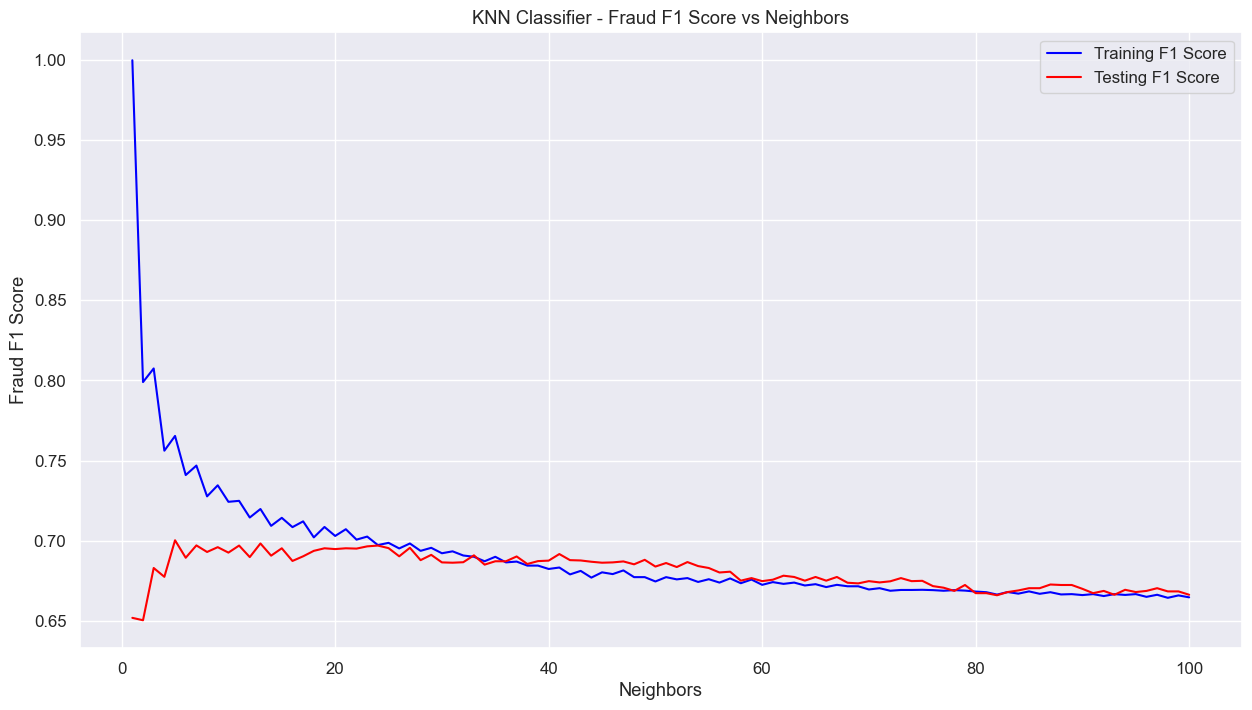

In [67]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_neighbor, best_train, best_test = get_bestParam(
    neighbor_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Neighbors: {best_neighbor}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Neighbors for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(neighbor_values, fraud_train_f1_score, color='blue')
plt.plot(neighbor_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('KNN Classifier - Fraud F1 Score vs Neighbors')
plt.xlabel('Neighbors')
plt.ylabel('Fraud F1 Score')
plt.show()

In [68]:
# Create model and fit model to the training data.
knn = KNeighborsClassifier(n_neighbors=best_neighbor)
knn.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = knn.predict(X_train)
y_test_predicted = knn.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with n_neighbors = {best_neighbor}\n')
print('\t\t     KNN Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t     KNN Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_neighbors = 5

		     KNN Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9010    0.9455    0.9227     12019
    fraud (1)     0.8258    0.7132    0.7654      4355

     accuracy                         0.8837     16374
    macro avg     0.8634    0.8294    0.8441     16374
 weighted avg     0.8810    0.8837    0.8809     16374
 

		     KNN Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8841    0.9146    0.8991      3011
    fraud (1)     0.7375    0.6667    0.7003      1083

     accuracy                         0.8490      4094
    macro avg     0.8108    0.7907    0.7997      4094
 weighted avg     0.8453    0.8490    0.8465      4094
 



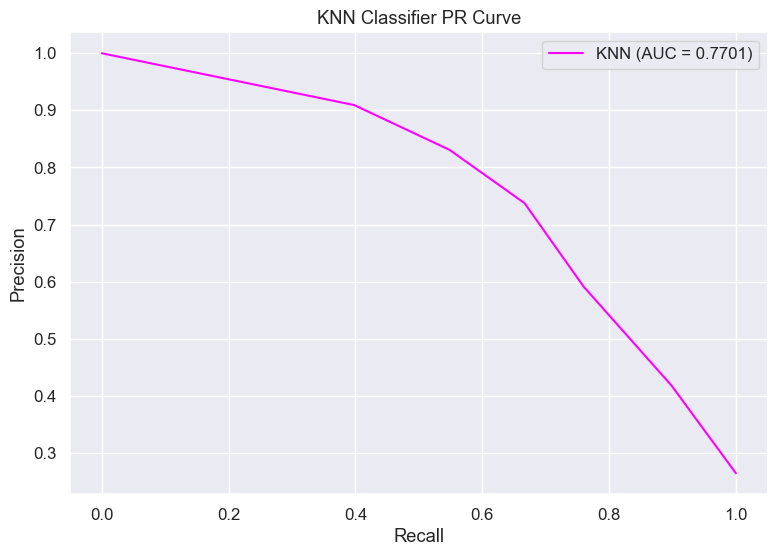

In [70]:
# Predict class probabilities for testing data.
y_score = knn.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
knn_auc = auc(knn_recall, knn_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(knn_recall, knn_precision, color='magenta')
plt.legend([f'KNN (AUC = {knn_auc})'])
plt.title('KNN Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [71]:
save_metrics()

<a id="section-six"></a>
## Multi-Layer Perceptron (MLP) Classifier
### Choosing a `max_iter` value that would produce the highest validation accuracy score.

In [73]:
from sklearn.neural_network import MLPClassifier

Best Max Iterations: 135
Training Accuracy: 0.9160864785635764
Validation Accuracy: 0.906253817026994


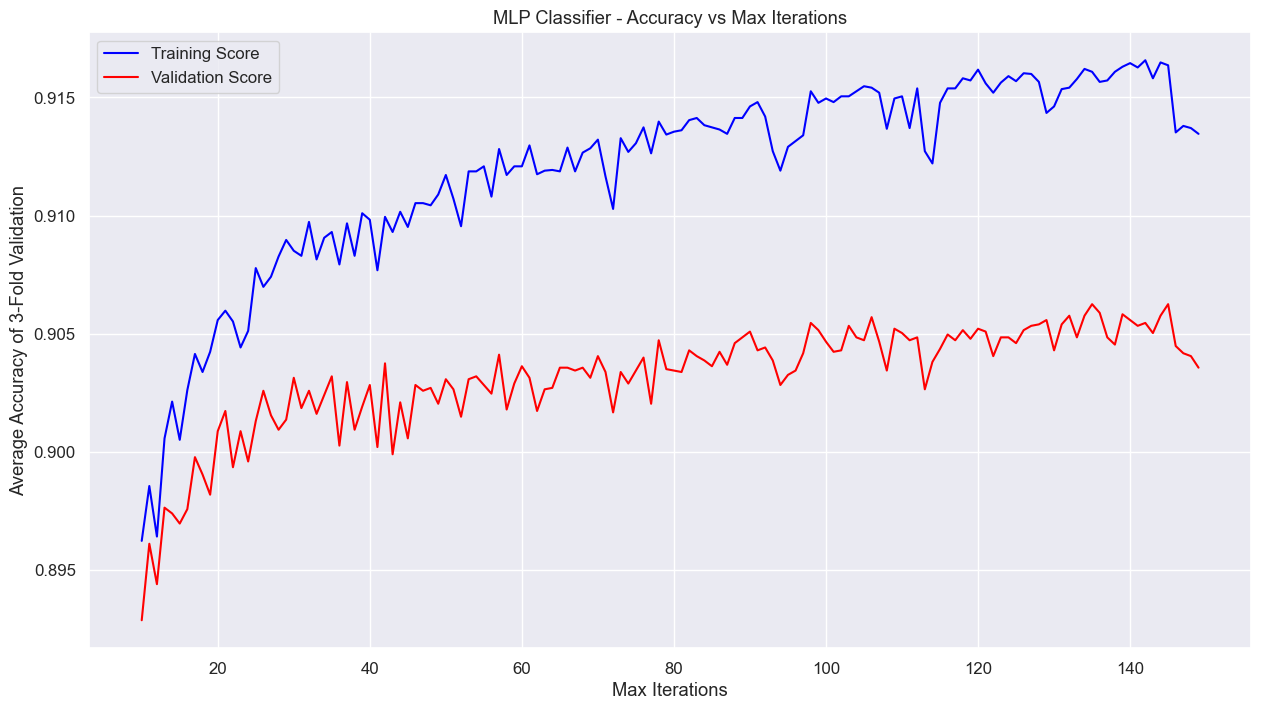

In [74]:
# Create model.
mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='tanh',
                    random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
max_iter_values = np.arange(10, 150, 1)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(mlp, X_train, y_train, 
                                              param_name='max_iter', 
                                              param_range=max_iter_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_max_iter, best_train, best_valid = get_bestParam(max_iter_values, train_scores, 
                                                      valid_scores)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, train_scores, color='blue')
plt.plot(max_iter_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title('MLP Classifier - Accuracy vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [75]:
# Create model and fit model to the training data.
mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='tanh',
                    max_iter=best_max_iter, random_state=random_seed)
mlp.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = mlp.predict(X_train)
y_test_predicted = mlp.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t  MLP Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  MLP Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 135

		  MLP Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9139    0.9720    0.9421     12019
    fraud (1)     0.9064    0.7472    0.8191      4355

     accuracy                         0.9122     16374
    macro avg     0.9101    0.8596    0.8806     16374
 weighted avg     0.9119    0.9122    0.9094     16374
 

		  MLP Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9066    0.9611    0.9331      3011
    fraud (1)     0.8703    0.7248    0.7909      1083

     accuracy                         0.8986      4094
    macro avg     0.8885    0.8430    0.8620      4094
 weighted avg     0.8970    0.8986    0.8955      4094
 



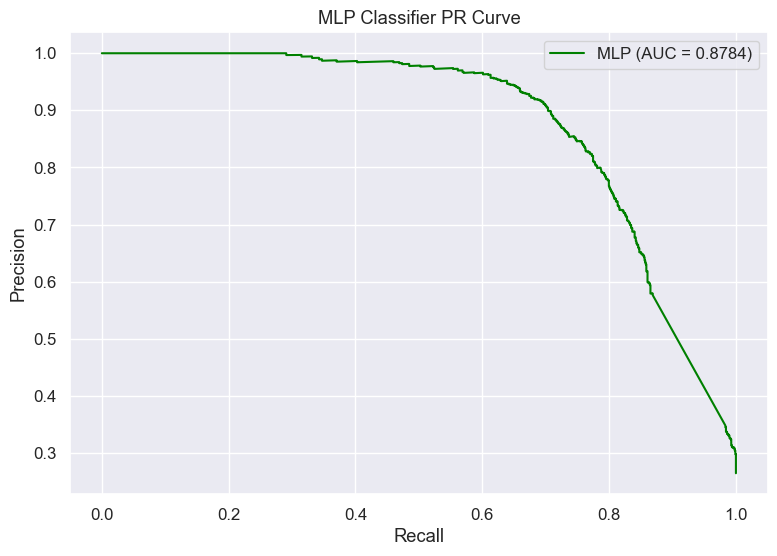

In [77]:
# Predict class probabilities for testing data.
y_score = mlp.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
mlp_auc = auc(mlp_recall, mlp_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(mlp_recall, mlp_precision, color='green')
plt.legend([f'MLP (AUC = {mlp_auc})'])
plt.title('MLP Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `max_iter` value that would produce the highest testing F1 score.

In [79]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for max_iter in max_iter_values:
    # Create model and fit model to the training data.
    mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='tanh',
                    max_iter=max_iter, random_state=random_seed)
    mlp.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = mlp.predict(X_train)
    y_test_predicted = mlp.predict(X_test)
    
    # Calculate F1 score for training and testing data.    
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Max Iterations: 80
Training F1 Score: 0.8181
Testing F1 Score: 0.7971


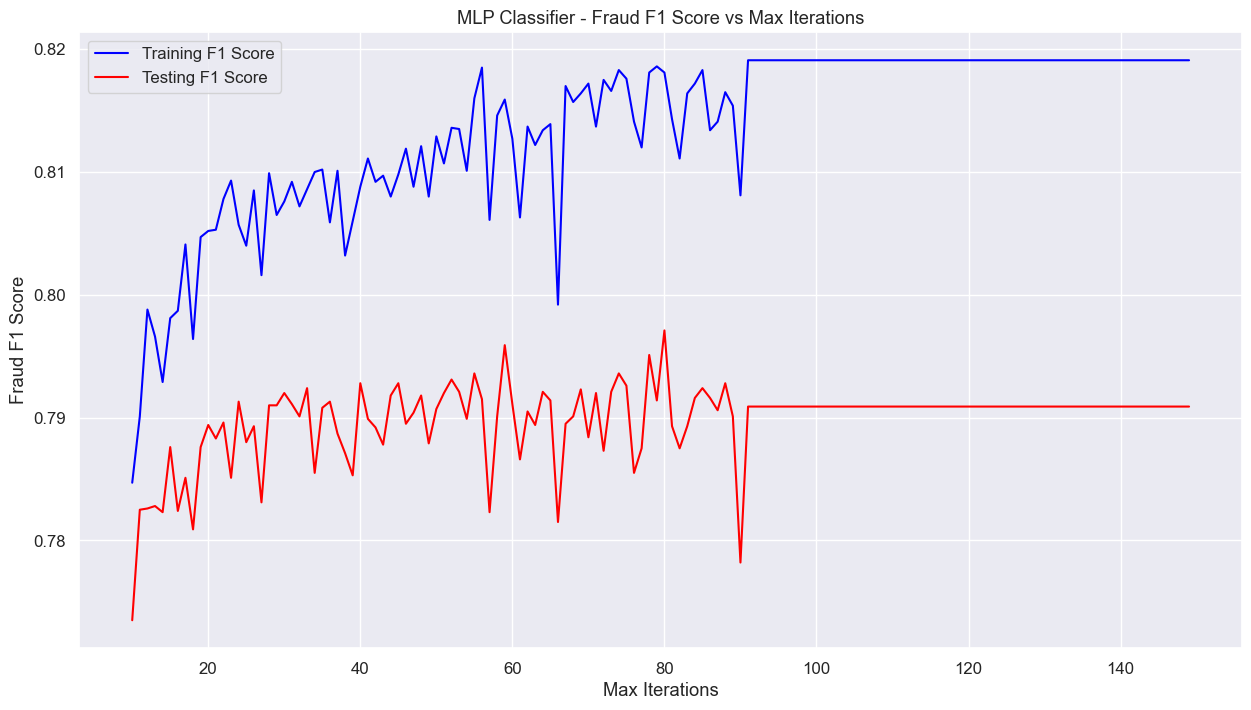

In [80]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_max_iter, best_train, best_test = get_bestParam(
    max_iter_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, fraud_train_f1_score, color='blue')
plt.plot(max_iter_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('MLP Classifier - Fraud F1 Score vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Fraud F1 Score')
plt.show()

In [81]:
# Create model and fit model to the training data.
mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='tanh',
                    max_iter=best_max_iter, random_state=random_seed)
mlp.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = mlp.predict(X_train)
y_test_predicted = mlp.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t  MLP Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  MLP Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 80

		  MLP Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9102    0.9783    0.9430     12019
    fraud (1)     0.9245    0.7336    0.8181      4355

     accuracy                         0.9132     16374
    macro avg     0.9173    0.8560    0.8805     16374
 weighted avg     0.9140    0.9132    0.9098     16374
 

		  MLP Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9064    0.9678    0.9361      3011
    fraud (1)     0.8896    0.7221    0.7971      1083

     accuracy                         0.9028      4094
    macro avg     0.8980    0.8449    0.8666      4094
 weighted avg     0.9020    0.9028    0.8993      4094
 



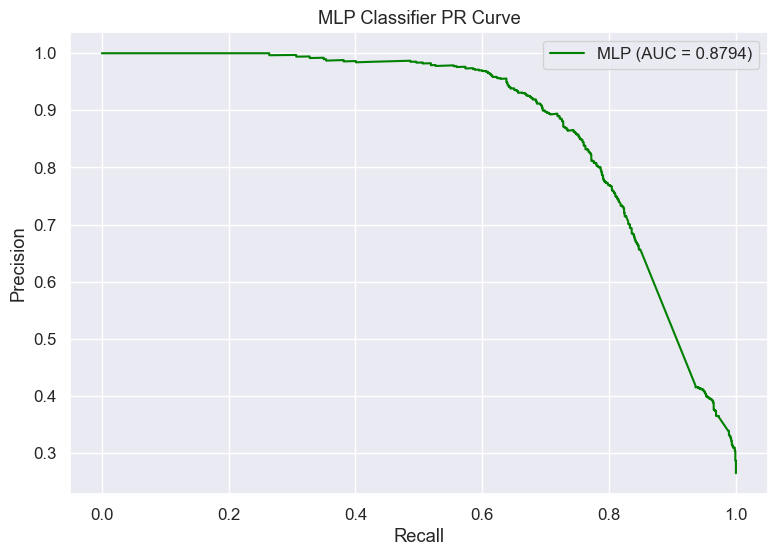

In [83]:
# Predict class probabilities for testing data.
y_score = mlp.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
mlp_auc = auc(mlp_recall, mlp_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(mlp_recall, mlp_precision, color='green')
plt.legend([f'MLP (AUC = {mlp_auc})'])
plt.title('MLP Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [84]:
save_metrics()

<a id="section-seven"></a>
## Logistic Regression
### Choosing a `max_iter` value that would produce the highest validation accuracy score.

In [86]:
from sklearn.linear_model import LogisticRegression

Best Max Iterations: 165
Training Accuracy: 0.8861304507145475
Cross Validation Accuracy: 0.882924148039575


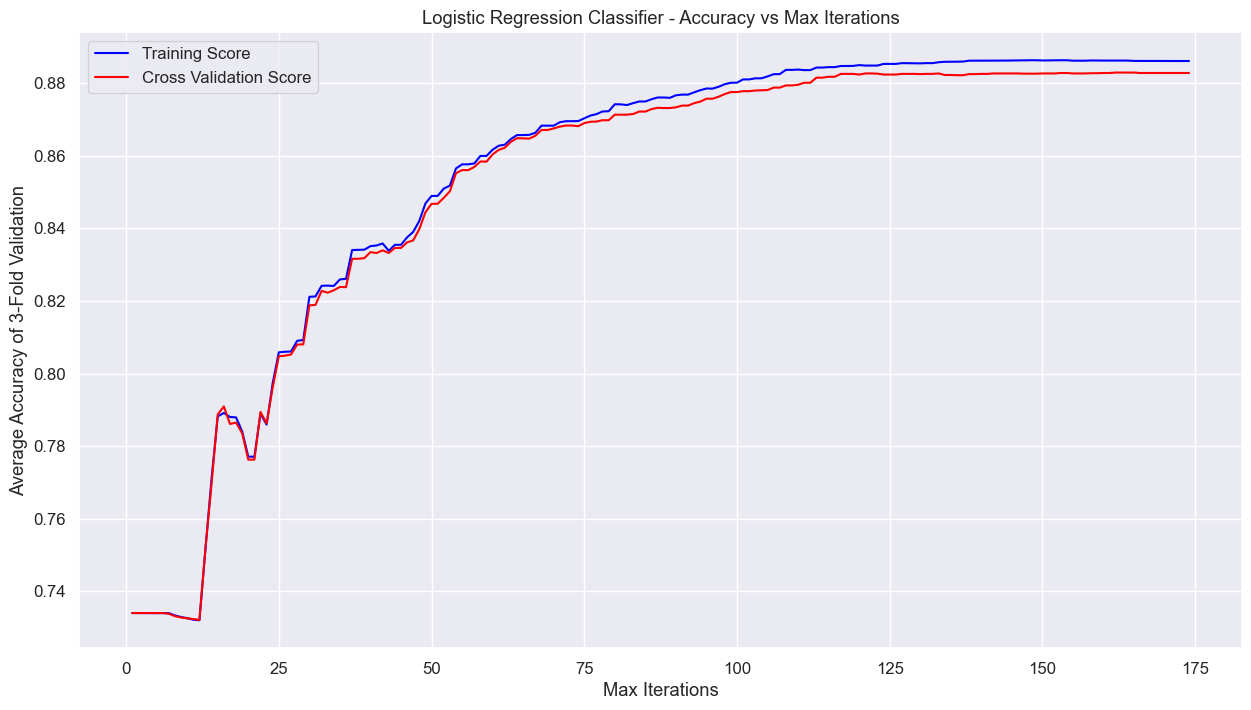

In [87]:
# Create model
lrg = LogisticRegression(solver='newton-cg', random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
max_iter_values = np.arange(1, 175, 1)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(lrg, X_train, y_train, 
                                              param_name='max_iter', 
                                              param_range=max_iter_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_max_iter, best_train, best_valid = get_bestParam(max_iter_values, train_scores, 
                                                      valid_scores)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training Accuracy: {best_train}')
print(f'Cross Validation Accuracy: {best_valid}')

# Plot Accuracy vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, train_scores, color='blue')
plt.plot(max_iter_values, valid_scores, color='red')
plt.legend(['Training Score','Cross Validation Score'])
plt.title('Logistic Regression Classifier - Accuracy vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [88]:
# Create model and fit model to the training data.
lrg = LogisticRegression(solver='newton-cg', random_state=random_seed, 
                         max_iter=best_max_iter)
lrg.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = lrg.predict(X_train)
y_test_predicted = lrg.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t  Logistic Regression (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  Logistic Regression (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 165

		  Logistic Regression (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8820    0.9727    0.9251     12019
    fraud (1)     0.8948    0.6409    0.7469      4355

     accuracy                         0.8845     16374
    macro avg     0.8884    0.8068    0.8360     16374
 weighted avg     0.8854    0.8845    0.8777     16374
 

		  Logistic Regression (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8843    0.9668    0.9237      3011
    fraud (1)     0.8753    0.6482    0.7448      1083

     accuracy                         0.8825      4094
    macro avg     0.8798    0.8075    0.8343      4094
 weighted avg     0.8819    0.8825    0.8764      4094
 



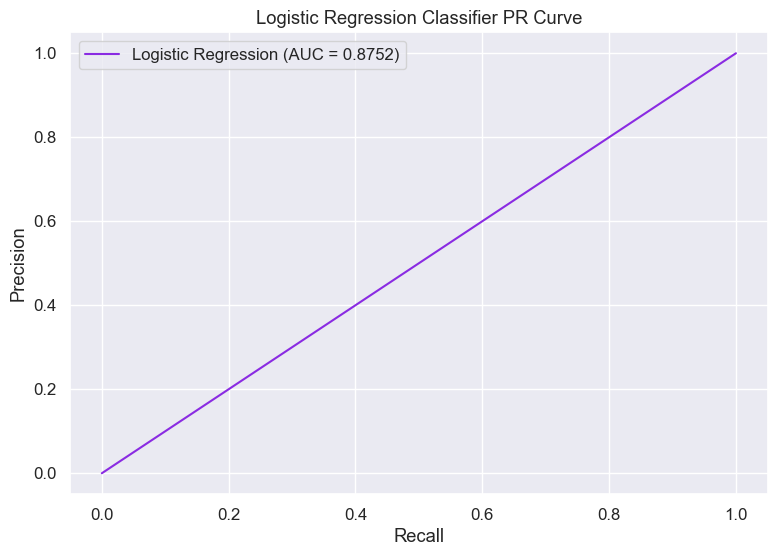

In [90]:
# Predict class probabilities for testing data.
y_score = lrg.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
lrg_precision, lrg_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
lrg_auc = auc(lrg_recall, lrg_precision).__round__(4)

plt.figure(figsize=(9,6))            
plt.plot(lrg_recall, lrg_recall, color='blueviolet')
plt.legend([f'Logistic Regression (AUC = {lrg_auc})'])
plt.title(f'Logistic Regression Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `max_iter` value that would produce the highest testing F1 score.

In [92]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for max_iter in max_iter_values:
    # Create model and fit model to the training data.
    lrg = LogisticRegression(solver='newton-cg', random_state=random_seed, 
                             max_iter=max_iter)
    lrg.fit(X_train, y_train)
    
    # Predict training & testing class.
    y_train_predicted = lrg.predict(X_train)
    y_test_predicted = lrg.predict(X_test)
    
    # Calculate F1 score for training and testing data.    
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Max Iterations: 129
Training F1 Score: 0.7478
Testing F1 Score: 0.7471


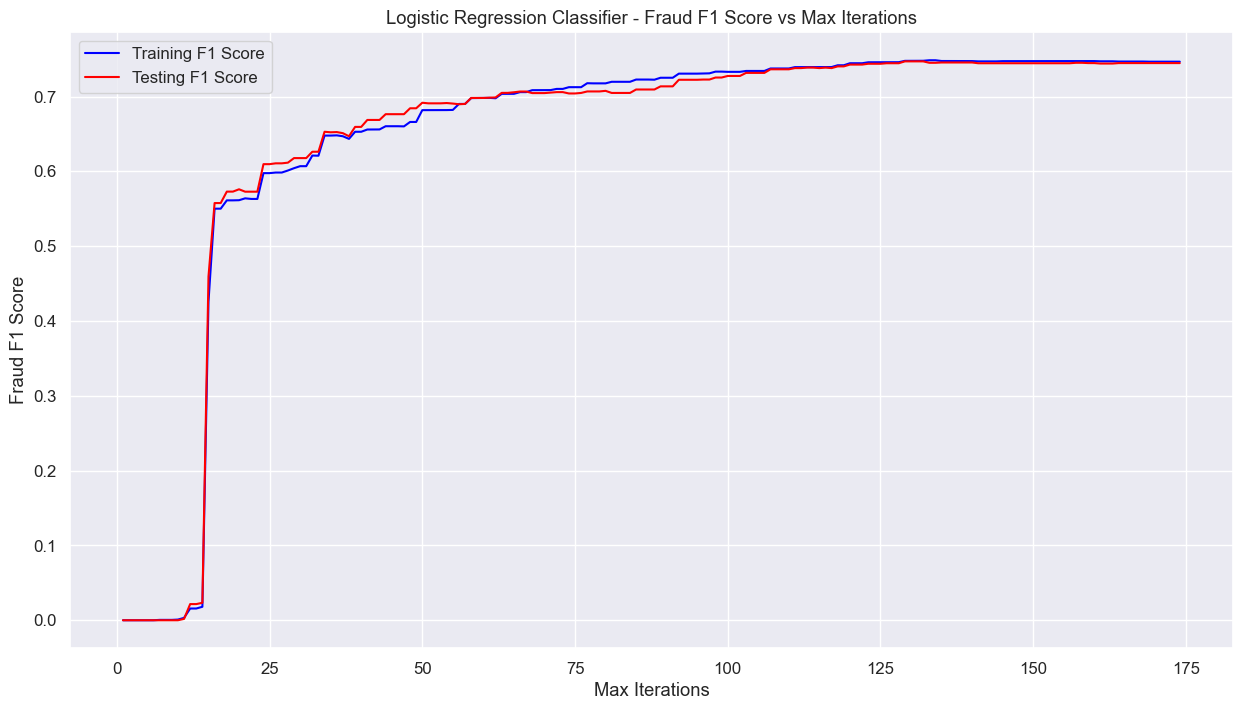

In [93]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_max_iter, best_train, best_test = get_bestParam(
    max_iter_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, fraud_train_f1_score, color='blue')
plt.plot(max_iter_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('Logistic Regression Classifier - Fraud F1 Score vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel(f'Fraud F1 Score')
plt.show()

In [94]:
# Create model and fit model to the training data.
lrg = LogisticRegression(solver='newton-cg', random_state=random_seed, 
                         max_iter=best_max_iter)
lrg.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = lrg.predict(X_train)
y_test_predicted = lrg.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t  Logistic Regression (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  Logistic Regression (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 129

		  Logistic Regression (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8822    0.9730    0.9254     12019
    fraud (1)     0.8961    0.6416    0.7478      4355

     accuracy                         0.8849     16374
    macro avg     0.8892    0.8073    0.8366     16374
 weighted avg     0.8859    0.8849    0.8782     16374
 

		  Logistic Regression (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8847    0.9681    0.9245      3011
    fraud (1)     0.8798    0.6491    0.7471      1083

     accuracy                         0.8837      4094
    macro avg     0.8823    0.8086    0.8358      4094
 weighted avg     0.8834    0.8837    0.8776      4094
 



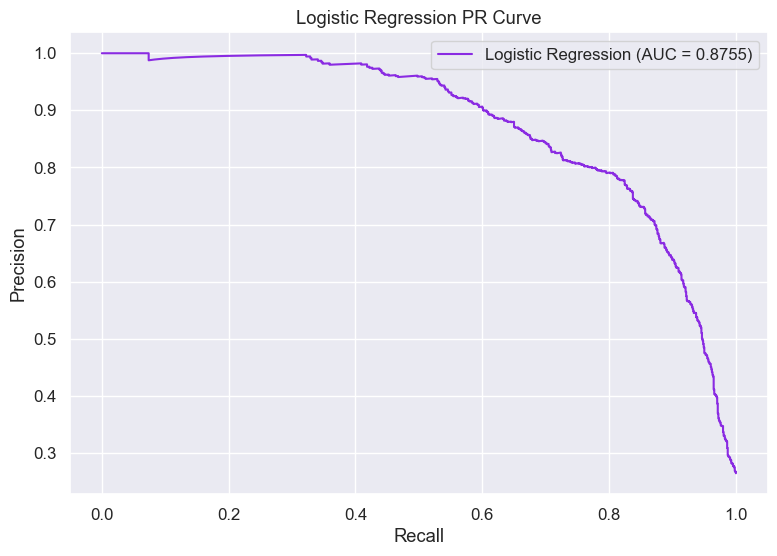

In [96]:
# Predict class probabilities for testing data.
y_score = lrg.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
lrg_precision, lrg_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
lrg_auc = auc(lrg_recall, lrg_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(lrg_recall, lrg_precision, color='blueviolet')
plt.legend([f'Logistic Regression (AUC = {lrg_auc})'])
plt.title('Logistic Regression PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [97]:
save_metrics()

<a id="section-eight"></a>
## Random Forest Classifier
### Choosing a `max_iter` value that would produce the highest validation accuracy score.

In [99]:
from sklearn.ensemble import RandomForestClassifier

Best Estimator: 137
Training Accuracy: 0.9999083913521436
Validation Accuracy: 0.9302552827653597


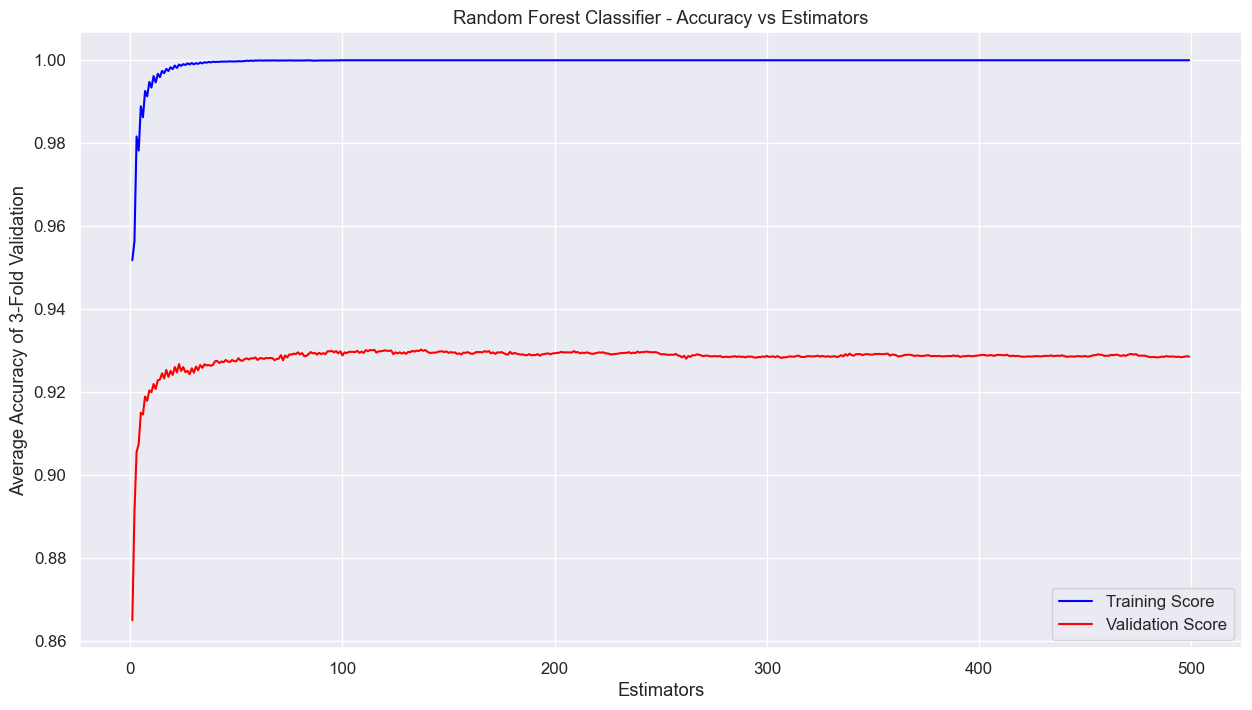

In [100]:
# Create model
rfc = RandomForestClassifier(random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
estimator_values = np.arange(1, 500, 1)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(rfc, X_train, y_train, 
                                              param_name='n_estimators', 
                                              param_range=estimator_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_estimator, best_train, best_valid = get_bestParam(estimator_values, train_scores, 
                                                       valid_scores)

# Display best parameter values.
print(f'Best Estimator: {best_estimator}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Estimators for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(estimator_values, train_scores, color='blue')
plt.plot(estimator_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title('Random Forest Classifier - Accuracy vs Estimators')
plt.xlabel('Estimators')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [101]:
# Create model and fit model to the training data.
rfc = RandomForestClassifier(n_estimators=best_estimator, random_state=random_seed)
rfc.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = rfc.predict(X_train)
y_test_predicted = rfc.predict(X_test)

# Display classification report for training and testing data.
print(f'Classification Report with n_estimators = {best_estimator}\n')
print('\t\t  Random Forest Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  Random Forest Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_estimators = 137

		  Random Forest Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9999    0.9999    0.9999     12019
    fraud (1)     0.9998    0.9998    0.9998      4355

     accuracy                         0.9999     16374
    macro avg     0.9998    0.9998    0.9998     16374
 weighted avg     0.9999    0.9999    0.9999     16374
 

		  Random Forest Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9377    0.9691    0.9531      3011
    fraud (1)     0.9053    0.8209    0.8610      1083

     accuracy                         0.9299      4094
    macro avg     0.9215    0.8950    0.9071      4094
 weighted avg     0.9291    0.9299    0.9288      4094
 



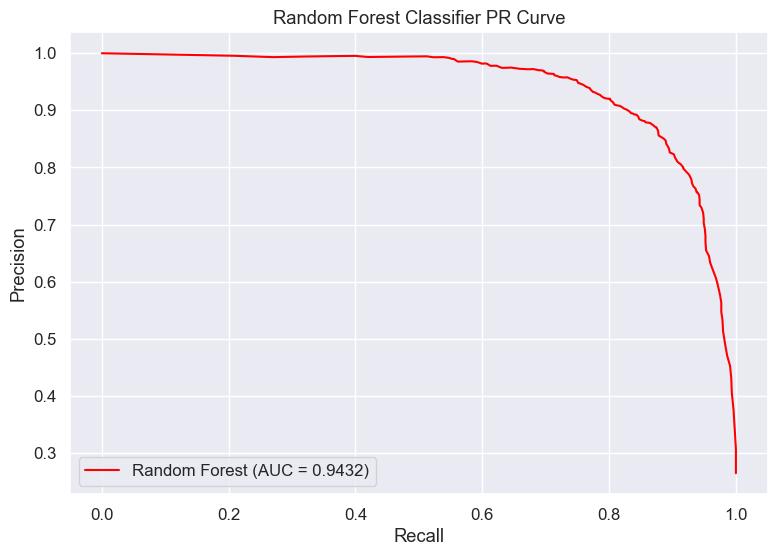

In [103]:
# Predict class probabilities for testing data.
y_score = rfc.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
rfc_auc = auc(rfc_recall, rfc_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(rfc_recall, rfc_precision, color='red')
plt.legend([f'Random Forest (AUC = {rfc_auc})'])
plt.title('Random Forest Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `max_iter` value that would produce the highest testing F1 score.

In [105]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for estimators in estimator_values:
    # Create model and fit model to the training data.
    rfc = RandomForestClassifier(n_estimators=estimators, random_state=random_seed)
    rfc.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = rfc.predict(X_train)
    y_test_predicted = rfc.predict(X_test)
    
    # Calculate F1 score for training and testing data.
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Estimator: 269
Training F1 Score: 0.9998
Testing F1 Score: 0.8653


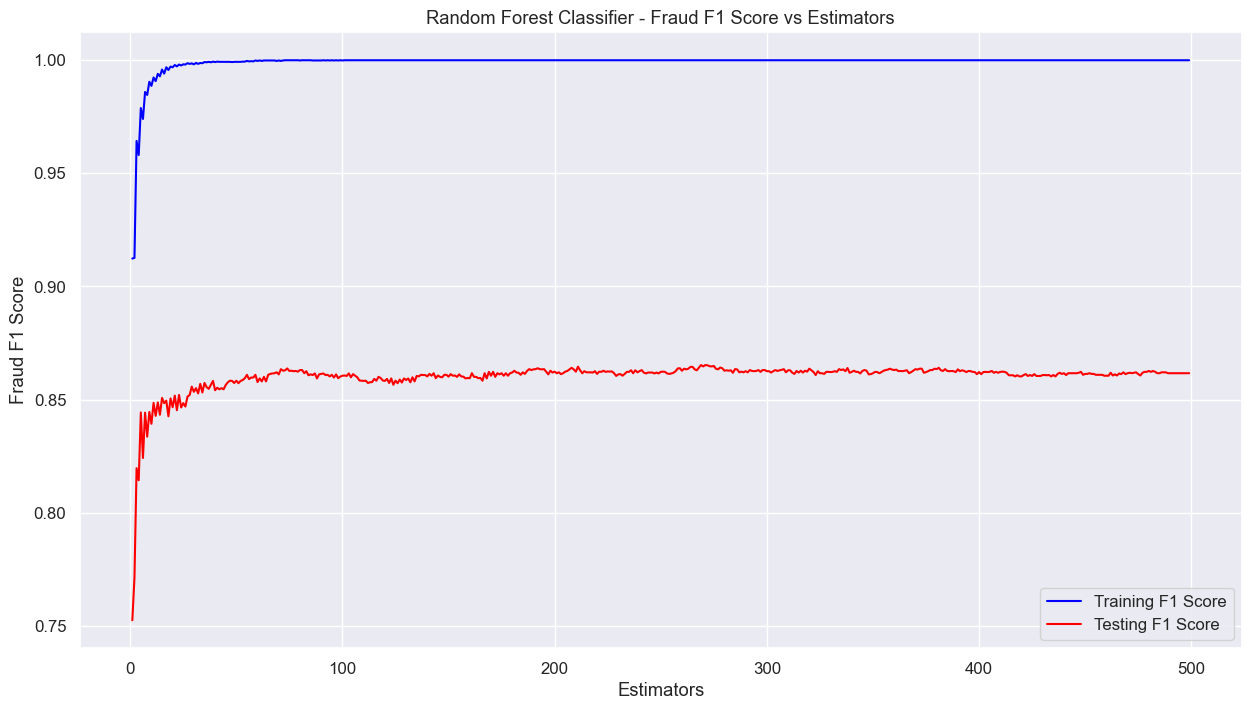

In [106]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_estimator, best_train, best_test = get_bestParam(
    estimator_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Estimator: {best_estimator}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Fraud F1 Score vs Estimators for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(estimator_values, fraud_train_f1_score, color='blue')
plt.plot(estimator_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('Random Forest Classifier - Fraud F1 Score vs Estimators')
plt.xlabel('Estimators')
plt.ylabel('Fraud F1 Score')
plt.show()

In [107]:
# Create model and fit model to the training data.
rfc = RandomForestClassifier(n_estimators=best_estimator, random_state=random_seed)
rfc.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = rfc.predict(X_train)
y_test_predicted = rfc.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with n_estimators = {best_estimator}\n')
print('\t\t  Random Forest Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t  Random Forest Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with n_estimators = 269

		  Random Forest Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9999    0.9999    0.9999     12019
    fraud (1)     0.9998    0.9998    0.9998      4355

     accuracy                         0.9999     16374
    macro avg     0.9998    0.9998    0.9998     16374
 weighted avg     0.9999    0.9999    0.9999     16374
 

		  Random Forest Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9381    0.9721    0.9548      3011
    fraud (1)     0.9138    0.8218    0.8653      1083

     accuracy                         0.9323      4094
    macro avg     0.9259    0.8969    0.9101      4094
 weighted avg     0.9317    0.9323    0.9311      4094
 



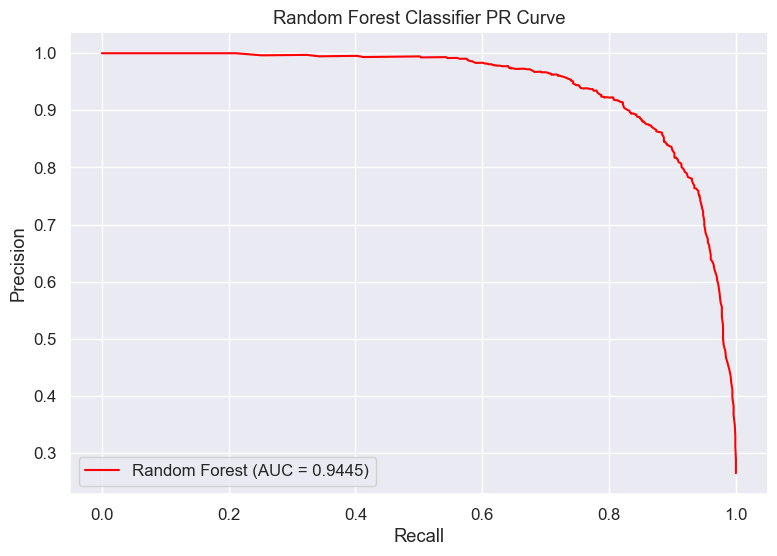

In [109]:
# Predict class probabilities for testing data.
y_score = rfc.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
rfc_auc = auc(rfc_recall, rfc_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(rfc_recall, rfc_precision, color='red')
plt.legend([f'Random Forest (AUC = {rfc_auc})'])
plt.title('Random Forest Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [110]:
save_metrics()

<a id="section-nine"></a>
## Support Vector Machine (SVM)
### Choosing a `max_iter` value that would produce the highest validation accuracy score.

In [112]:
from sklearn.svm import SVC

Best Max Iterations: 2780
Training Accuracy: 0.9604861365579578
Validation Accuracy: 0.8589226823012092


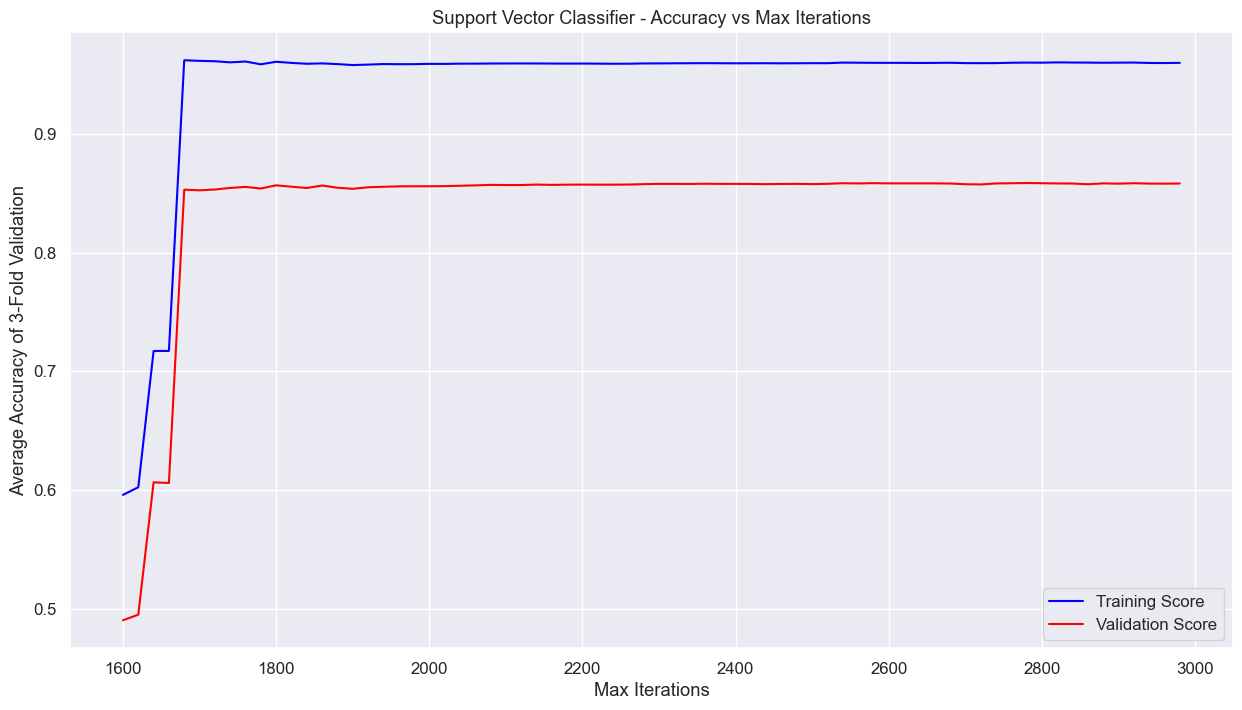

In [113]:
# Create model
svm = SVC(gamma='auto', random_state=random_seed)

# Generates a list that starts at minimum, ends at maximum, and increments by step.
max_iter_values = np.arange(1600, 3000, 20)

# Calculate training and validation accuracies.
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 
                                              param_name='max_iter', 
                                              param_range=max_iter_values, cv=cv)

# Average training and validation accuracy.
train_scores = np.mean(train_scores, axis=1)
valid_scores = np.mean(valid_scores, axis=1)

# Obtain the best parameter value that would produce the highest validation accuracy.
best_max_iter, best_train, best_valid = get_bestParam(max_iter_values, train_scores, 
                                                      valid_scores)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training Accuracy: {best_train}')
print(f'Validation Accuracy: {best_valid}')

# Plot Accuracy vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, train_scores, color='blue')
plt.plot(max_iter_values, valid_scores, color='red')
plt.legend(['Training Score','Validation Score'])
plt.title('Support Vector Classifier - Accuracy vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel(f'Average Accuracy of {cv}-Fold Validation')
plt.show()

In [114]:
# Create model and fit model to the training data.
svm = SVC(gamma='auto', random_state=random_seed, 
          max_iter=best_max_iter, probability=True)
svm.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = svm.predict(X_train)
y_test_predicted = svm.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t   SVM Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t   SVM Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 2780

		   SVM Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9791    0.9668    0.9729     12019
    fraud (1)     0.9115    0.9431    0.9270      4355

     accuracy                         0.9605     16374
    macro avg     0.9453    0.9549    0.9499     16374
 weighted avg     0.9611    0.9605    0.9607     16374
 

		   SVM Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8765    0.9455    0.9097      3011
    fraud (1)     0.8061    0.6297    0.7071      1083

     accuracy                         0.8620      4094
    macro avg     0.8413    0.7876    0.8084      4094
 weighted avg     0.8579    0.8620    0.8561      4094
 



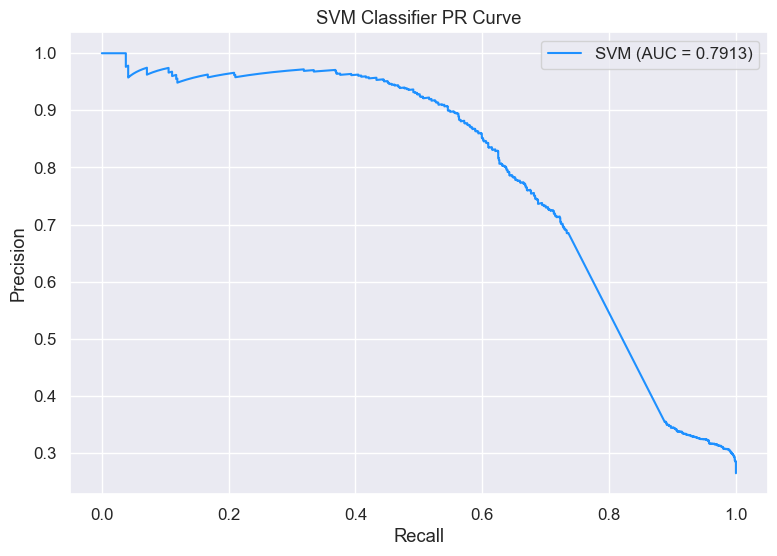

In [116]:
# Predict class probabilities for testing data.
y_score = svm.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
svm_auc = auc(svm_recall, svm_precision).__round__(4)
              
plt.figure(figsize=(9,6))
plt.plot(svm_recall, svm_precision, color='dodgerblue')
plt.legend([f'SVM (AUC = {svm_auc})'])
plt.title('SVM Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Choosing a `max_iter` value that would produce the highest testing F1 score.

In [118]:
fraud_train_f1_score = []
fraud_test_f1_score = []

for max_iter in max_iter_values:
    # Create model and fit model to the training data.
    svm = SVC(gamma='auto', random_state=random_seed, max_iter=max_iter)
    svm.fit(X_train, y_train)
    
    # Predict training and testing class.
    y_train_predicted = svm.predict(X_train)
    y_test_predicted = svm.predict(X_test)
    
    # Calculate F1 score for training and testing data.
    fraud_train_f1_score.append((f1_score(y_train, y_train_predicted)).__round__(4))
    fraud_test_f1_score.append((f1_score(y_test, y_test_predicted)).__round__(4))

Best Max Iterations: 2500
Training F1 Score: 0.9331
Testing F1 Score: 0.7216


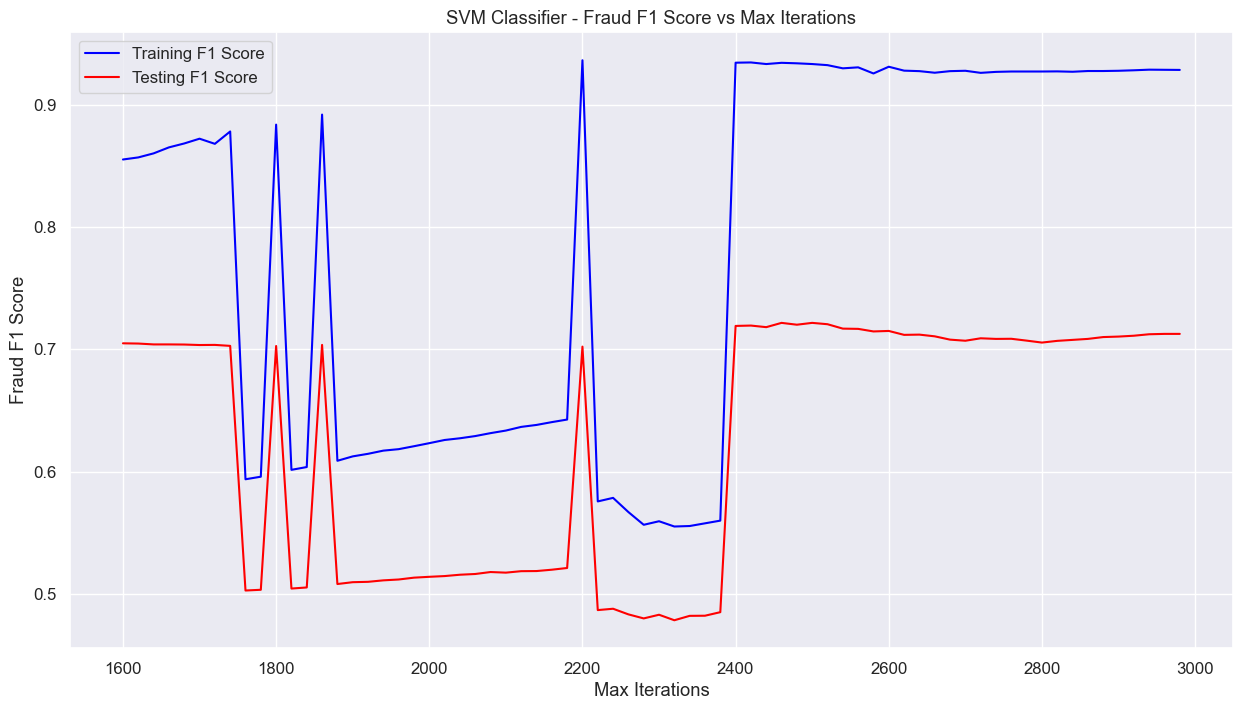

In [119]:
# Obtain the best parameter value that would produce the highest testing F1 score.
best_max_iter, best_train, best_test = get_bestParam(
    max_iter_values, fraud_train_f1_score, fraud_test_f1_score)

# Display best parameter values.
print(f'Best Max Iterations: {best_max_iter}')
print(f'Training F1 Score: {best_train}')
print(f'Testing F1 Score: {best_test}')

# Plot Accuracy vs Max Iterations for training and testing data.
plt.figure(figsize=(15,8))
plt.plot(max_iter_values, fraud_train_f1_score, color='blue')
plt.plot(max_iter_values, fraud_test_f1_score, color='red')
plt.legend(['Training F1 Score','Testing F1 Score'])
plt.title('SVM Classifier - Fraud F1 Score vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel(f'Fraud F1 Score')
plt.show()

In [120]:
# Create model and fit model to the training data.
svm = SVC(gamma='auto', random_state=random_seed, 
          max_iter=best_max_iter, probability=True)
svm.fit(X_train, y_train)

# Predict training and testing class.
y_train_predicted = svm.predict(X_train)
y_test_predicted = svm.predict(X_test)

# Display classification report for training & testing data.
print(f'Classification Report with max_iter = {best_max_iter}\n')
print('\t\t   SVM Classifier (Train)')
print('\t---------------------------------------------')
print(classification_report(y_train, y_train_predicted, 
                            target_names=target_names, digits=4), '\n')
print('\t\t   SVM Classifier (Test)')
print('\t---------------------------------------------')
print(classification_report(y_test, y_test_predicted, 
                            target_names=target_names, digits=4), '\n')

Classification Report with max_iter = 2500

		   SVM Classifier (Train)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.9831    0.9671    0.9750     12019
    fraud (1)     0.9130    0.9541    0.9331      4355

     accuracy                         0.9636     16374
    macro avg     0.9480    0.9606    0.9540     16374
 weighted avg     0.9644    0.9636    0.9639     16374
 

		   SVM Classifier (Test)
	---------------------------------------------
               precision    recall  f1-score   support

non-fraud (0)     0.8874    0.9319    0.9091      3011
    fraud (1)     0.7800    0.6713    0.7216      1083

     accuracy                         0.8630      4094
    macro avg     0.8337    0.8016    0.8154      4094
 weighted avg     0.8590    0.8630    0.8595      4094
 



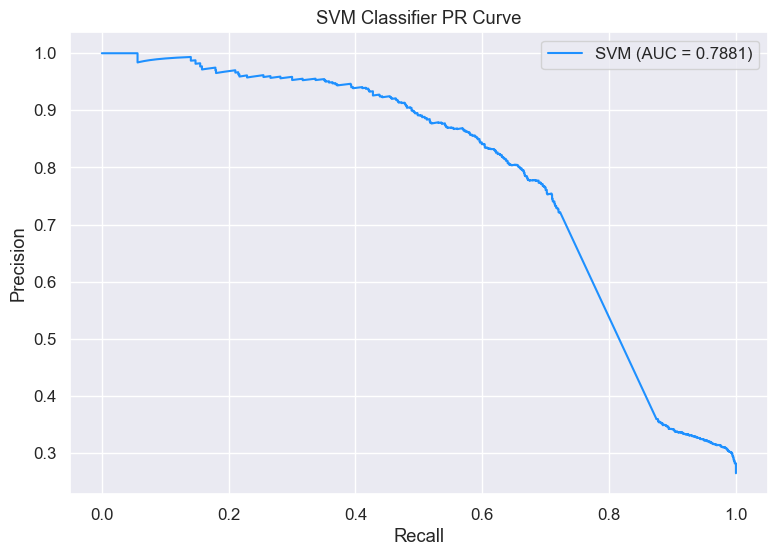

In [122]:
# Predict class probabilities for testing data.
y_score = svm.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds.
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_score)

# Calculate and plot AUC-PR.
svm_auc = auc(svm_recall, svm_precision).__round__(4)
              
plt.figure(figsize=(9,6))            
plt.plot(svm_recall, svm_precision, color='dodgerblue')
plt.legend([f'SVM (AUC = {svm_auc})'])
plt.title('SVM Classifier PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [123]:
save_metrics()

<a id="section-ten"></a>
# Comparing ML Models

I will be comparing different metrics (e.g., accuracy, F1 score and AUC-PR) to determine which model is the most efficient at predicting fraudulent transactions. 

In [125]:
from operator import itemgetter # Used in sorting procedure.
import seaborn as sns
sns.set(style="whitegrid")

### Model vs Accuracy

Compare training and testing accuracies for all the models.

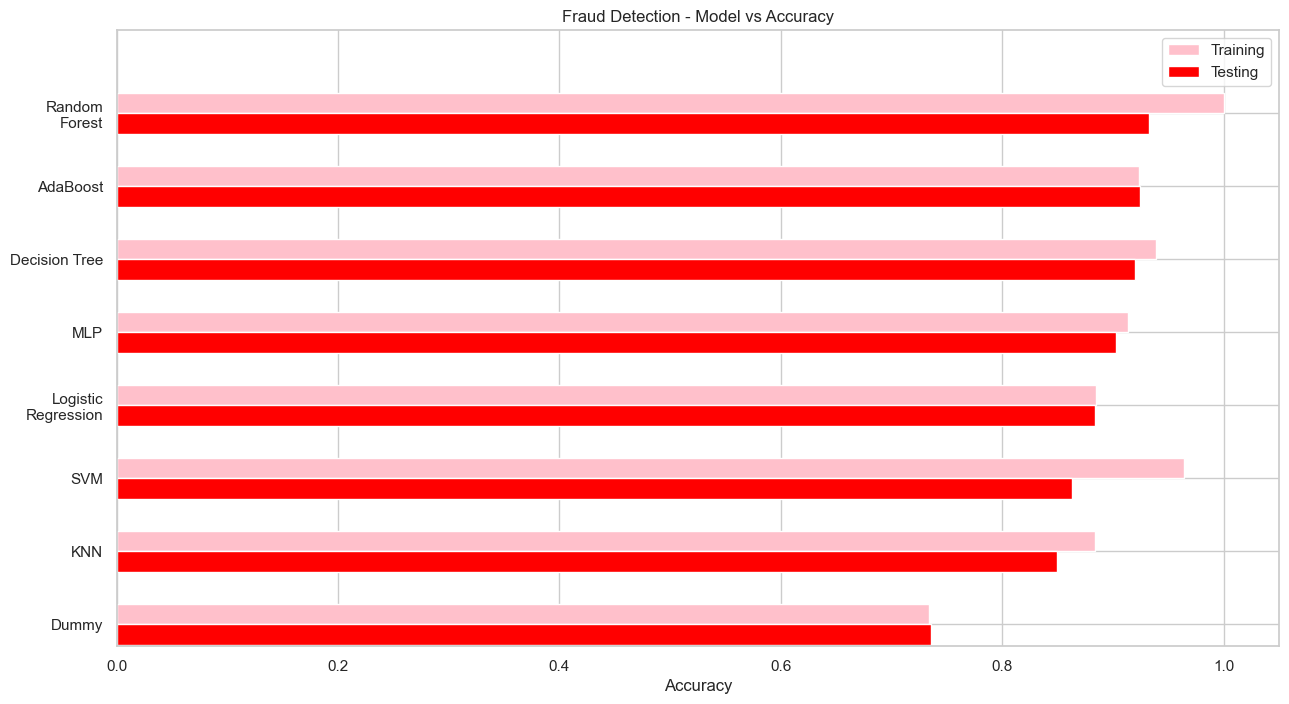

In [127]:
D = [] # Used to create list of tuples.

# Create list of tuples with classifer name, training accuracy, and testing accuracy.
for i in range(len(clf_names)):
    D.append((clf_names[i], train_accs[i], test_accs[i]))

# Sort list of tuples by test accuracy.
Dsort = sorted(D, key=itemgetter(2), reverse=False) 

clf_names_0 = [x[0] for x in Dsort] # Recreate list with sorted classifier (model) names.
train_accs = [x[1] for x in Dsort] # Recreate list with sorted training accuracies. 
test_accs = [x[2] for x in Dsort] # Recreate list with sorted testing accuracies. 

ind = np.arange(len(clf_names_0)) # Barchart index
width = 0.28 # Barwidth

plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.barh(ind, train_accs, width, align='center', color='pink', label='Training') 
ax.barh(ind - width, test_accs, width, align='center', color='red', label='Testing') 
ax.set(yticks=ind - width/2, yticklabels=clf_names_0, ylim=[2*width - 1, len(clf_names_0)])
plt.xlabel('Accuracy')
plt.title('Fraud Detection - Model vs Accuracy')
plt.legend()
plt.savefig('img/fraud_detection_model_accuracy.png', bbox_inches='tight')
plt.show()

The **Random Forest** model has the highest training and testing accuracy. The training accuracy is **0.9999** and the testing accuracy is **0.9323**.

### Model vs F1 Fraud Score

Compare training and testing fraud F1 scores for all the models.

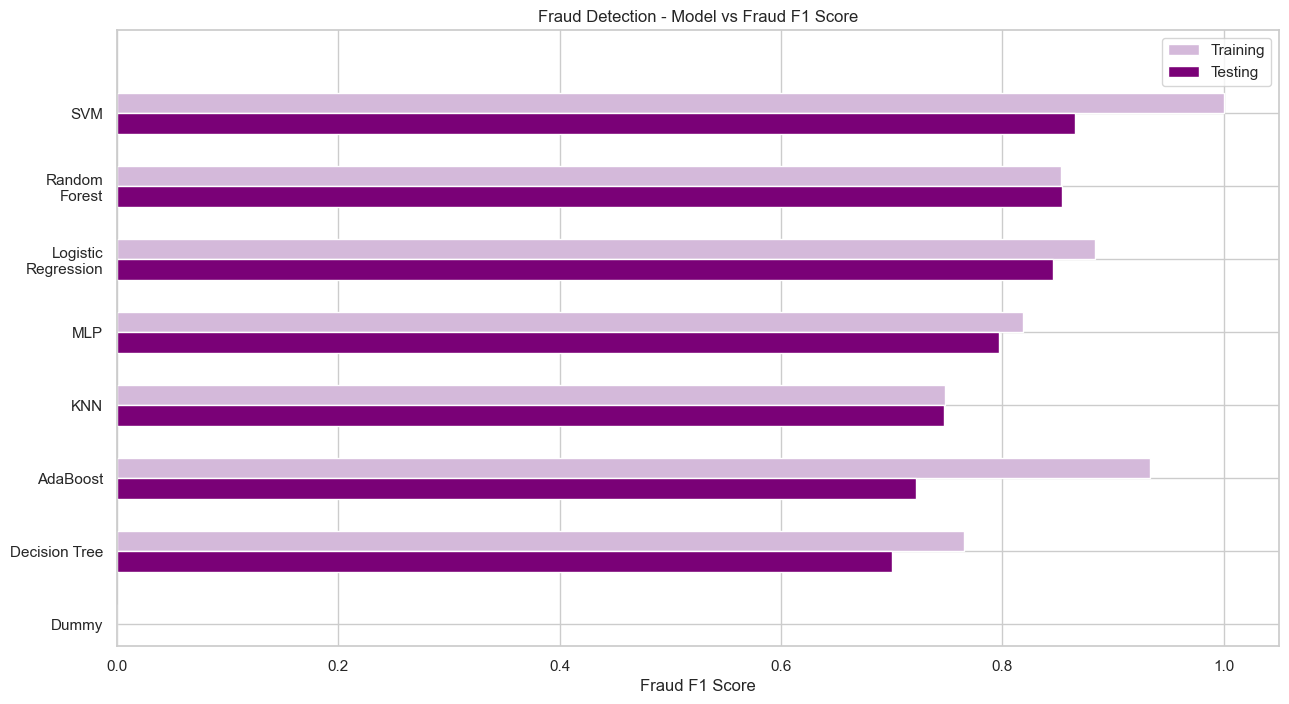

In [228]:
D = [] # Used to create list of tuples.

for i in range(len(clf_names)):
    D.append((clf_names[i], train_f1_scores[i], test_f1_scores[i]))
       
Dsort = sorted(D, key=itemgetter(2), reverse=False) # Sort the list by test F1 score.

clf_names_1 = [x[0] for x in Dsort] # Recreate list with sorted classifier (model) names.
train_f1_scores = [x[1] for x in Dsort] # Recreate list with sorted false positives. 
test_f1_scores = [x[2] for x in Dsort] # Recreate list with sorted false negatives. 
  
ind = np.arange(len(clf_names_1)) # Barchart index
width = 0.28 

plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.barh(ind, train_f1_scores, width, align='center', color='#D4B9DA', label='Training') 
ax.barh(ind - width, test_f1_scores, width, align='center', color='#7A0177', label='Testing') 
ax.set(yticks=ind - width/2, yticklabels=clf_names_1, ylim=[2*width - 1, len(clf_names_1)])
plt.xlabel('Fraud F1 Score')
plt.title('Fraud Detection - Model vs Fraud F1 Score')
plt.legend()
plt.savefig('img/fraud_f1_score.png', bbox_inches='tight')
plt.show()

The **Random Forest** model has the highest training and testing fraud F1 score. The training fraud F1 score is **0.9998** and the testing fraud F1 score is **0.8653**.

### False Values vs Model

Compare the testing data false-positives and false-negatives for each model.

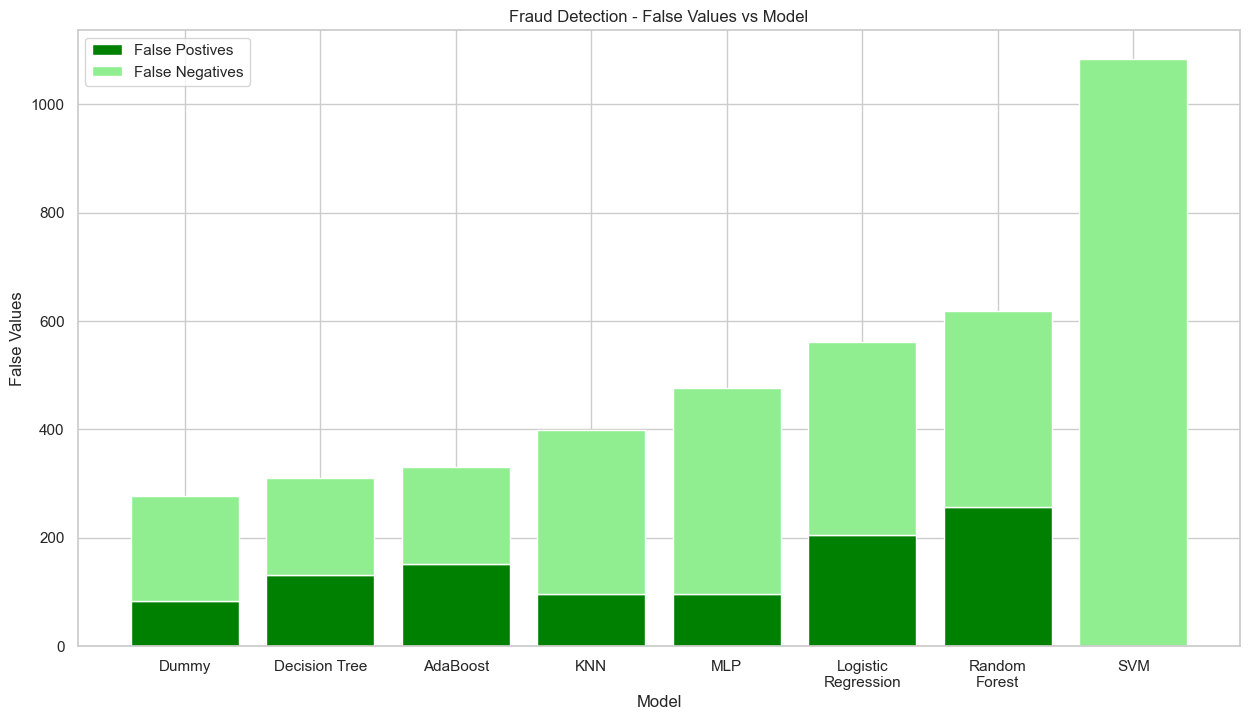

In [248]:
D = [] # Used to create list of tuples.

for i in range(len(clf_names)):
    D.append((clf_names[i], false_pos[i], false_neg[i], false_pos[i]+false_neg[i]))

# Sort the list by total false-postives and false-negatives.
Dsort = sorted(D, key=itemgetter(3), reverse=False) 

clf_names_2 = [x[0] for x in Dsort] # Recreate list with sorted classifier (model) names.
false_pos = [x[1] for x in Dsort] # Recreate list with sorted false positives. 
false_neg = [x[2] for x in Dsort] # Recreate list with sorted false negatives. 
  
# Plot bars in stack manner
plt.figure(figsize=(15,8))
plt.bar(clf_names_2, false_pos, color='green')
plt.bar(clf_names_2, false_neg, bottom=false_pos, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('False Values')
plt.title('Fraud Detection - False Values vs Model')
plt.legend(['False Postives', 'False Negatives'])
plt.savefig('img/fraud_detection_false_values.png', dpi=300, bbox_inches='tight')
plt.show()

The **Random Forest** model has the least amount of misclassified transactions with **84 false-positives** and **193 false-negatives**. This means that this model misclassifed **277 transactions out of the 4094 transactions** (6.766% error) in the testing data.

### AUC-PR: Area Under The (Precision-Recall) Curve

Compare the testing data AUC-PR for each model.

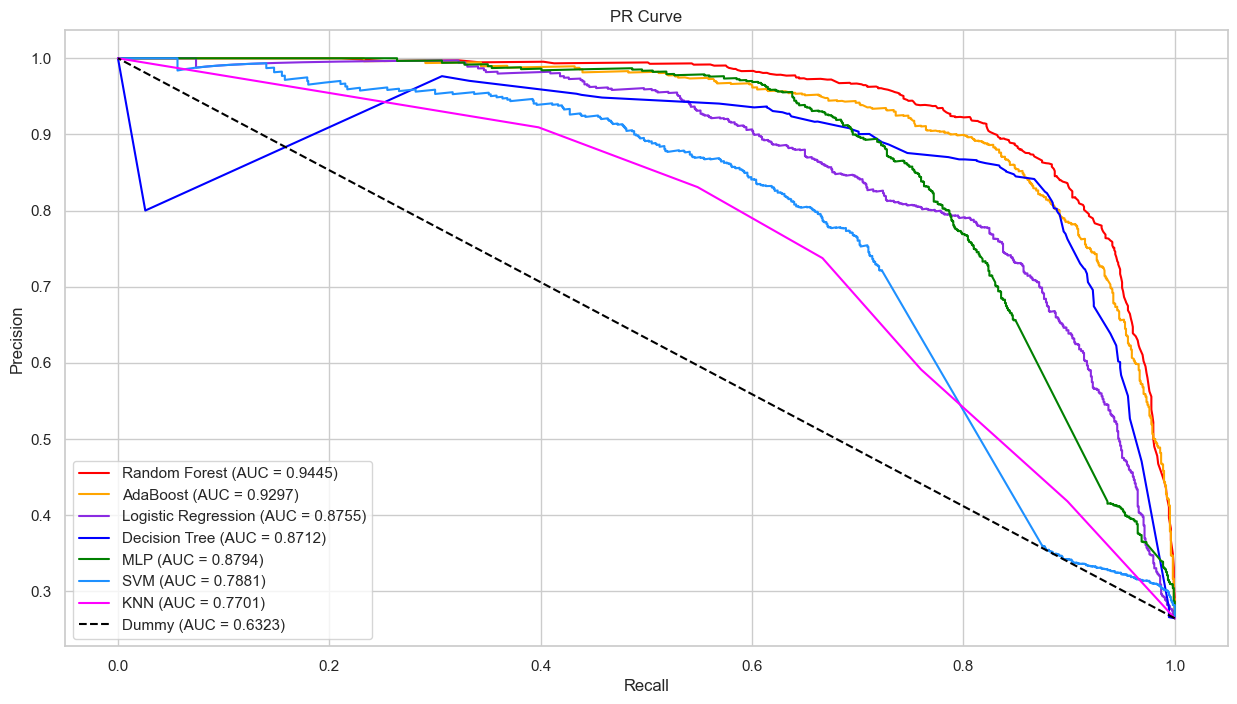

In [250]:
plt.figure(figsize=(15,8))
plt.plot(rfc_recall, rfc_precision, color='red')
plt.plot(ada_recall, ada_precision, color='orange')
plt.plot(lrg_recall, lrg_precision, color='blueviolet')
plt.plot(dtc_recall, dtc_precision, color='blue')
plt.plot(mlp_recall, mlp_precision, color='green')
plt.plot(svm_recall, svm_precision, color='dodgerblue')
plt.plot(knn_recall, knn_precision, color='magenta')
plt.plot(dum_recall, dum_precision, color='black', linestyle='--')
plt.legend([f'Random Forest (AUC = {rfc_auc})', 
            f'AdaBoost (AUC = {ada_auc})',
            f'Logistic Regression (AUC = {lrg_auc})', 
            f'Decision Tree (AUC = {dtc_auc})',
            f'MLP (AUC = {mlp_auc})', 
            f'SVM (AUC = {svm_auc})',
            f'KNN (AUC = {knn_auc})', 
            f'Dummy (AUC = {dum_auc})'])
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('img/PR_Curve.png', dpi=300, bbox_inches='tight')
plt.show()

Once again, **Random Forest** performed the best with the highest AUC-PR.

<a id="section-eleven"></a>
# Conclusion

All the models performed better than the baseline, but the **Random Forest** model performed the best overall. It has the highest accuracy, F1 score, AUC-PR and it has the least amount of cumulative false values (FP + FN). The **AdaBoost** and **Decision Tree** models are also great choices as well. They both have less false-negatives than the **Random Forest** model, which in my opinion is more consequential than false-positives.